In [1]:
# !pip install shap

In [2]:
# !pip install --user -q ydata-profiling

In [37]:
# import sys
# print(sys.version)

3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]


In [38]:
# pip-review --auto

Note: you may need to restart the kernel to use updated packages.



Usage:   
  C:\ProgramData\anaconda3\python.exe -m pip <command> [options]

no such option: -r


## Описание проекта. Телеком

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

1. Описание услуг

Оператор предоставляет два основных типа услуг:

* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:
* Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
* Выделенная линия технической поддержки (Tech Support);
* Облачное хранилище файлов для резервного копирования данных (Online Backup);
* Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

2. Описание данных

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:

* contract — информация о договорах;
* personal — персональные данные клиентов;
* internet — информация об интернет-услугах;
* phone — информация об услугах телефонии.

`Таблица telecom.contract`

customerID — ID абонента;

BeginDate — дата начала действия договора;

EndDate — дата окончания действия договора;

Type — тип оплаты: раз в год-два или ежемесячно;

PaperlessBilling — электронный расчётный лист;

PaymentMethod — тип платежа;

MonthlyCharges — расходы за месяц;

TotalCharges — общие расходы абонента.

`Таблица personal`

customerID — ID пользователя;

gender — пол;

SeniorCitizen — является ли абонент пенсионером;

Partner — есть ли у абонента супруг или супруга;

Dependents — есть ли у абонента дети.

`Таблица telecom.internet`

customerID — ID пользователя;

InternetService — тип подключения;

OnlineSecurity — блокировка опасных сайтов;

OnlineBackup — облачное хранилище файлов для резервного копирования данных;

DeviceProtection — антивирус;

TechSupport — выделенная линия технической поддержки;

StreamingTV — стриминговое телевидение;

StreamingMovies — каталог фильмов.

`Таблица telecom.phone`

customerID — ID пользователя;

MultipleLines — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

In [2]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

import datetime
from datetime import datetime, timedelta
import time

RANDOM_STATE = 19032024


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score, \
                            make_scorer, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer

# from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier, Pool

# import lightgbm as lgb
# from lightgbm import LGBMClassifier

import math
from math import ceil

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim





import matplotlib.pyplot as plt
import seaborn as sns



# import random


# from skorch.callbacks import EpochScoring, EarlyStopping
# from skorch.dataset import ValidSplit 
from skorch import NeuralNetClassifier

import shap

# from sklearn.compose import ColumnTransformer
# from torch.utils.data import TensorDataset, DataLoader


import warnings
warnings.filterwarnings("ignore")

In [3]:
db_config = {
'user': 'praktikum_student',# имя пользователя,
'pwd': 'Sdf4$2;d-d30pp',# пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения,
'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string) 

In [5]:
# query = '''
# SELECT *
# FROM telecom.contract;
# '''


# with engine.connect() as conn:
#     contract = pd.read_sql(
#         sql=query,
#         con=conn.connection
#     )
    
# contract

# query = '''
# SELECT *
# FROM telecom.personal;
# '''

# # personal = pd.read_sql_query(query, con=engine)
# # personal

# with engine.connect() as conn:
#     personal = pd.read_sql(
#         sql=query,
#         con=conn.connection
#     )
# personal

# query = '''
# SELECT *
# FROM telecom.internet;
# '''

# # internet = pd.read_sql_query(query, con=engine)
# # internet

# with engine.connect() as conn:
#     internet = pd.read_sql(
#         sql=query,
#         con=conn.connection
#     )
# internet

# query = '''
# SELECT *
# FROM telecom.phone;
# '''

# # phone = pd.read_sql_query(query, con=engine)
# # phone

# with engine.connect() as conn:
#     phone = pd.read_sql(
#         sql=query,
#         con=conn.connection
#     )
# phone
# internet.columns = internet.iloc[0]
# internet = internet.drop(index=0)
# phone.columns = phone.iloc[0]
# phone = phone.drop(index=0)
# phone

# contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
# contract['EndDate'] = pd.to_datetime(contract['EndDate'])

# pd.set_option('display.max_columns', 25)
# for i in ['contract', 'personal', 'internet', 'phone']:
#     globals()[i].columns = globals()[i].columns.str.replace(' ', '_').str.lower()
    
# data_final = (contract.merge(personal, on='customerid')
#                       .merge(internet, on='customerid', how='outer')
#                       .merge(phone, on='customerid', how='outer'))

# data_final['enddate'] = data_final['enddate'].fillna('Not')

# def get_target(row):
#     if row['enddate'] == 'Not':
#         target = 0
#     else:
#         target = 1
#     return target

# data_final['target'] = data_final.apply(lambda x: get_target(x), axis=1)


# actual_date = datetime.strptime('2020-02-01','%Y-%m-%d')
# # data_final['enddate'] = data_final['enddate'].fillna(actual_date)
# data_final['enddate'] = data_final['enddate'].replace(['Not'], actual_date)
# data_final['contr_duration'] = (data_final['enddate'] - data_final['begindate']).astype(str).apply(lambda x: int(x[:-5]))

# data_final['begin_year'] = data_final['begindate'].apply(lambda x: x.year)
# data_final['begin_month'] = data_final['begindate'].apply(lambda x: x.month)

# data_final[data_final['totalcharges'].isna()]
# data_final['totalcharges'] = data_final['totalcharges'].fillna(0)

# idx = data_final[data_final['totalcharges'].isna()].index.to_list()
# data_final.drop(labels=idx, axis=0, inplace=True)

# data_final = data_final.fillna('unconnected')
# data_final = data_final.set_index('customerid')





# # data_final['period_payment']=(data_final['totalcharges']/data_final['monthlycharges'])
# # data_final = data_final.drop(['totalcharges'], axis = 1)
# # data_final = data_final.drop(['period_payment'], axis = 1)
# data_final = data_final.drop(['contr_duration'], axis = 1)
# # data_final = data_final.drop(['begin_year'], axis = 1)
# # data_final = data_final.drop(['begin_month'], axis = 1)

# # data_final = data_final.drop(['totalcharges', 'period_payment'], axis = 1)

# data_final.drop(['begindate', 'enddate'], axis=1, inplace=True)


# def split(df):

#     target = df['target']
#     features = df.drop(['target'], axis=1)
    
#     features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
#                                                                                 random_state=RANDOM_STATE, 
#                                                                                 stratify=target,
#                                                                                 shuffle = True)
#     print('Размер обучающей выборки:', features_train.shape[0], 'строк - ', round(features_train.shape[0]/df.shape[0] * 100), "%")
#     print('Размер тестовой выборки:', features_test.shape[0], 'строк - ', round(features_test.shape[0]/df.shape[0] * 100), "%")
#     return features_train, target_train, features_test, target_test

# features_train, target_train, features_test, target_test = split(data_final);

# features_train.dtypes
# cat_col = []
# num_col = []
# for i in features_train.columns:
#     if features_train[i].dtype == 'object':
#         cat_col.append(i)
#     else:
#         num_col.append(i)
# print('cat_col', cat_col)
# print('num_col', num_col)

# # def mean_feature(row):
# #     result = dict[row[i]]
# #     return result
# # features_train['target'] = target_train

# # feature_list = ['Type', 
# #                 'PaperlessBilling',
# #                 'PaymentMethod',                            
# #                 'SeniorCitizen',                
# #                 'Partner',                
# #                 'Dependents',                
# #                 'InternetService',                
# #                 'OnlineSecurity',                              
# #                 'OnlineBackup',                
# #                 'StreamingTV',               
# #                 'StreamingMovies']
# # feature_list = ['Type']


# # for i in feature_list:
# #     dict = features_train.groupby(i).agg({'target': 'mean'})['target'].to_dict()
# #     feature_name = 'mean_' + i
# #     features_train[feature_name] = features_train.apply(lambda x: mean_feature(x), axis=1)
# #     features_test[feature_name] = features_test.apply(lambda x: mean_feature(x), axis=1)
# # features_train = features_train.drop(['target'], axis=1)    


# cat_col = []
# num_col = []
# for i in features_train.columns:
#     if features_train[i].dtype == 'object':
#         cat_col.append(i)
#     else:
#         num_col.append(i)
# print('cat_col', cat_col)
# print('num_col', num_col)
# cat_features = cat_col
# print(cat_col, num_col)

# clf = CatBoostClassifier(
#     random_state = RANDOM_STATE,
# #     logging_level = 'Silent'
# )

# # 'learning_rate': [0.0001, 0.001, 0.01, 0.1]
# params = {
#     'learning_rate': [0.01]
# }

# clf_grid = GridSearchCV(estimator=clf, param_grid=params, scoring='roc_auc', cv=5, refit = True, n_jobs = -1)

# clf_grid.fit(features_train, target_train, cat_features=cat_features, verbose=False)
# print(clf_grid.best_score_)
# print(clf_grid.best_params_)

# cat_preds = clf_grid.predict(features_test)
# probabilities_test_cat = clf_grid.predict_proba(features_test)

# probabilities_one_test = probabilities_test_cat[:, 1]
# auc_roc = roc_auc_score(target_test, probabilities_one_test)
# print('Метрика auc_roc', auc_roc)

## Загрузка данных

### contract

In [6]:
query = '''
SELECT *
FROM telecom.contract;
'''

# contract = pd.read_sql_query(query, con=engine)
# contract

with engine.connect() as conn:
    contract = pd.read_sql(
        sql=query,
        con=conn.connection
    )
contract.head()

customerID   BeginDate     EndDate            Type PaperlessBilling  \
0  4472-LVYGI  2020-02-01        None        Two year              Yes   
1  3115-CZMZD  2020-02-01        None        Two year               No   
2  3668-QPYBK  2018-08-09  2019-12-01  Month-to-month              Yes   
3  5709-LVOEQ  2020-02-01        None        Two year               No   
4  9237-HQITU  2019-01-26  2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  
0  Bank transfer (automatic)           52.55           NaN  
1               Mailed check           20.25           NaN  
2               Mailed check           53.85        108.15  
3               Mailed check           80.85           NaN  
4           Electronic check           70.70        151.65

In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Для использования библиотеки Profile приведём данные 'BeginDate', 'EndDate' к формату datetime.

In [8]:
contract[['BeginDate', 'EndDate']].dtypes

BeginDate    object
EndDate      object
dtype: object

In [9]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'],format= "%Y/%m/%d")
contract['EndDate'] = pd.to_datetime(contract['EndDate'],format= "%Y/%m/%d")

In [10]:
contract[['BeginDate', 'EndDate']].dtypes

BeginDate    datetime64[ns]
EndDate      datetime64[ns]
dtype: object

In [11]:
profile_contract = ProfileReport(
    contract,
    title= 'Отчет по contract',
    minimal = True)
profile_contract

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Вывод**

Датафрейм contract содержит 7043 строк, 8 столбцов. В столбце EndDate только 1869 объектов, то есть 73.5% пропусков. В `TotalCharges` 0.2% пропусков. В остальных данных пропусков нет.

Есть разные типы данных:

`MonthlyCharges` и `TotalCharges` - численный тип;

`BeginDate` и `EndDate` - мы привели к типу datetime.

Даты заключения договоров в `BeginDate` начинаются с 2019-10-01. последняя дата заключения договора - 2020-01-01, что соответсвует дате выгрузки датасета.

Все идентификаторы пользователей `customerID` уникальны. Дубликатов нет. `EndDate` содержит дату завершения контракта с пользователем. Пропуски в столбце `EndDate` означают, что контракт с пользователем не завершён. На базе этого признака мы и составим целевой признак. 

### personal

In [12]:
query = '''
SELECT *
FROM telecom.personal;
'''

# personal = pd.read_sql_query(query, con=engine)
# personal

with engine.connect() as conn:
    personal = pd.read_sql(
        sql=query,
        con=conn.connection
    )
personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [13]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [14]:
profile_personal = ProfileReport(
    personal,
    title= 'Отчет по personal',
    minimal = True)
profile_personal

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Вывод**

Датафрейм personal содержит 7043 строк, 5 столбцов. Пропусков в данных нет.

Есть разные типы данных:

`SeniorCitizen` - численный тип;

Остальные - текстового типа.

Все идентификаторы пользователей `customerID` уникальны. Дубликатов нет.

### internet

In [15]:
query = '''
SELECT *
FROM telecom.internet;
'''

# internet = pd.read_sql_query(query, con=engine)
# internet

with engine.connect() as conn:
    internet = pd.read_sql(
        sql=query,
        con=conn.connection
    )
internet.head()

c1               c2              c3            c4  \
0  customerID  InternetService  OnlineSecurity  OnlineBackup   
1  7590-VHVEG              DSL              No           Yes   
2  5575-GNVDE              DSL             Yes            No   
3  3668-QPYBK              DSL             Yes           Yes   
4  7795-CFOCW              DSL             Yes            No   

                 c5           c6           c7               c8  
0  DeviceProtection  TechSupport  StreamingTV  StreamingMovies  
1                No           No           No               No  
2               Yes           No           No               No  
3                No           No           No               No  
4               Yes          Yes           No               No

Назначим первую строку в качестве имени столбцов.

In [16]:
internet.columns = internet.iloc[0]
internet = internet.drop(index=0)
internet.head()

0  customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
1  7590-VHVEG             DSL             No          Yes               No   
2  5575-GNVDE             DSL            Yes           No              Yes   
3  3668-QPYBK             DSL            Yes          Yes               No   
4  7795-CFOCW             DSL            Yes           No              Yes   
5  9237-HQITU     Fiber optic             No           No               No   

0 TechSupport StreamingTV StreamingMovies  
1          No          No              No  
2          No          No              No  
3          No          No              No  
4         Yes          No              No  
5          No          No              No

In [17]:
internet_description = ProfileReport(
    internet,
    title= 'Отчет по internet',
    minimal = True)
internet_description

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Вывод**

Датафрейм internet содержит 5517 строк, 8 столбцов. Пропусков в данных нет. Все текстового типа. Все идентификаторы пользователей `customerID` уникальны. Дубликатов нет. Строк меньше чем в personal и contract. Это говорит о том, что не все пользователи пользуются услугами интернета.

### phone

In [18]:
query = '''
SELECT *
FROM telecom.phone;
'''

# phone = pd.read_sql_query(query, con=engine)
# phone

with engine.connect() as conn:
    phone = pd.read_sql(
        sql=query,
        con=conn.connection
    )
phone.head()

c1             c2
0  customerID  MultipleLines
1  5575-GNVDE             No
2  3668-QPYBK             No
3  9237-HQITU             No
4  9305-CDSKC            Yes

In [19]:
phone.columns = phone.iloc[0]
phone = phone.drop(index=0)
phone.head()

0  customerID MultipleLines
1  5575-GNVDE            No
2  3668-QPYBK            No
3  9237-HQITU            No
4  9305-CDSKC           Yes
5  1452-KIOVK           Yes

In [20]:
phone_description = ProfileReport(
    phone,
    title= 'Отчет по phone',
    minimal = True)
phone_description

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Вывод**

Датафрейм phone содержит 6361 строк, 2 столбца. Пропусков в данных нет. Все идентификаторы пользователей `customerID` уникальны. Дубликатов нет. Строк меньше чем в personal и contract. Это говорит о том, что не все пользователи пользуются услугами телефонии.

## Объединение датафреймов

Объединим данные в датафрейм. Обратим внимание на то, что не все позьзователи подключены и к телефонии, и к интернету. Поэтому при объединении зададим параметр how='outer', чтобы не потерять данные.

In [21]:
pd.set_option('display.max_columns', 25)

In [22]:
### Перед объединением датафреймов приведём названия столбцов к нижнему регистру и уберём пробелы.
# for i in ['contract', 'personal', 'internet', 'phone']:
#     globals()[i].columns = globals()[i].columns.str.replace(' ', '_').str.lower()

    
# def rename_col(list):
#     new_list = []
#     for string in list:
#         str_new = string[0]
#         for char in string[1:]:
#             if char.isupper():
#                 str_new = str_new + '_' + char
#             elif char.islower():
#                 str_new = str_new + char
#             else:
#                 str_new = str_new.replace(char, '_')
#         str_new = str_new.lower()
#         new_list.append(str_new)

#     return new_list

# for i in ['contract', 'personal', 'internet', 'phone']:
#     globals()[i].columns = rename_col(globals()[i].columns.to_list())


# !pip install -q skimpy
# from skimpy import clean_columns
# # приводим названия колонок датасета к стилю snake_case
# contract = clean_columns(contract)

In [23]:
data = (contract.merge(personal, on='customerID')
                      .merge(internet, on='customerID', how='outer')
                      .merge(phone, on='customerID', how='outer'))
data.head()

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  0002-ORFBO 2019-02-08        NaT        One year              Yes   
1  0003-MKNFE 2018-11-13        NaT  Month-to-month               No   
2  0004-TLHLJ 2019-04-16 2020-01-01  Month-to-month              Yes   
3  0011-IGKFF 2019-04-12 2020-01-01  Month-to-month              Yes   
4  0013-EXCHZ 2019-03-17 2019-12-01  Month-to-month              Yes   

      PaymentMethod  MonthlyCharges  TotalCharges  gender  SeniorCitizen  \
0      Mailed check            65.6        593.30  Female              0   
1      Mailed check            59.9        542.40    Male              0   
2  Electronic check            73.9        280.85    Male              0   
3  Electronic check            98.0       1237.85    Male              1   
4      Mailed check            83.9        267.40  Female              1   

  Partner Dependents InternetService OnlineSecurity OnlineBackup  \
0     Yes        Yes             DSL             No          Yes   
1      No         No             DSL             No           No   
2      No         No     Fiber optic             No           No   
3     Yes         No     Fiber optic             No          Yes   
4     Yes         No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies MultipleLines  
0               No         Yes         Yes              No            No  
1               No          No          No             Yes           Yes  
2              Yes          No          No              No            No  
3              Yes          No         Yes             Yes            No  
4               No         Yes         Yes              No            No

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Выделим целевой признак. Если дата окончания контракта указана, значит контракт завершён.

In [25]:
data['EndDate'] = data['EndDate'].fillna('Not')

In [26]:
def get_target(row):
    if row['EndDate'] == 'Not':
        target = 0
    else:
        target = 1
    return target

In [27]:
data['target'] = data.apply(lambda x: get_target(x), axis=1)

In [28]:
data['target'].unique()

array([0, 1], dtype=int64)

Теперь создадим новый признак: длительность контракта. Для тех контрактов, которые не завершены посчитаем длительность относительно даты выгрузки датасета.

In [29]:
# actual_date = datetime.strptime('2020-02-01','%Y-%m-%d').date()
# actual_date = datetime.strptime('2020-02-01','%Y-%m-%d').date()
# data_final['contr_duration'] = (data_final['enddate'] - data_final['begindate']).astype(str)
# data_final['contr_duration'] = data_final['contr_duration'].apply(lambda x: int(x[:-5]))
# data_final.head()

actual_date = datetime.strptime('2020-02-01','%Y-%m-%d')
# data_final['enddate'] = data_final['enddate'].fillna(actual_date)
data['EndDate'] = data['EndDate'].replace(['Not'], actual_date)
data['duration'] = (data['EndDate'] - data['BeginDate']).astype(str).apply(lambda x: int(x[:-5]))

Создадим признаки год начала контракта, месяц начала контракта

In [30]:
### Создадим признаки год начала контракта, месяц начала контракта
data['begin_year'] = data['BeginDate'].apply(lambda x: x.year)
data['begin_month'] = data['BeginDate'].apply(lambda x: x.month)

In [31]:
data.head()

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  0002-ORFBO 2019-02-08 2020-02-01        One year              Yes   
1  0003-MKNFE 2018-11-13 2020-02-01  Month-to-month               No   
2  0004-TLHLJ 2019-04-16 2020-01-01  Month-to-month              Yes   
3  0011-IGKFF 2019-04-12 2020-01-01  Month-to-month              Yes   
4  0013-EXCHZ 2019-03-17 2019-12-01  Month-to-month              Yes   

      PaymentMethod  MonthlyCharges  TotalCharges  gender  SeniorCitizen  \
0      Mailed check            65.6        593.30  Female              0   
1      Mailed check            59.9        542.40    Male              0   
2  Electronic check            73.9        280.85    Male              0   
3  Electronic check            98.0       1237.85    Male              1   
4      Mailed check            83.9        267.40  Female              1   

  Partner Dependents InternetService OnlineSecurity OnlineBackup  \
0     Yes        Yes             DSL             No          Yes   
1      No         No             DSL             No           No   
2      No         No     Fiber optic             No           No   
3     Yes         No     Fiber optic             No          Yes   
4     Yes         No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies MultipleLines  \
0               No         Yes         Yes              No            No   
1               No          No          No             Yes           Yes   
2              Yes          No          No              No            No   
3              Yes          No         Yes             Yes            No   
4               No         Yes         Yes              No            No   

   target  duration  begin_year  begin_month  
0       0       358        2019            2  
1       0       445        2018           11  
2       1       260        2019            4  
3       1       264        2019            4  
4       1       259        2019            3

In [32]:
# data['begindate_ym'] = data["BeginDate"].dt.to_period("M")
# data.head()

In [33]:
data = data.set_index('customerID')

## Заполнение пропусков

Посмотрим на пропуски в `TotalCharges`

In [34]:
data[data['TotalCharges'].isna()]

BeginDate    EndDate      Type PaperlessBilling  \
customerID                                                    
1371-DWPAZ 2020-02-01 2020-02-01  Two year               No   
2520-SGTTA 2020-02-01 2020-02-01  Two year               No   
2775-SEFEE 2020-02-01 2020-02-01  Two year              Yes   
2923-ARZLG 2020-02-01 2020-02-01  One year              Yes   
3115-CZMZD 2020-02-01 2020-02-01  Two year               No   
3213-VVOLG 2020-02-01 2020-02-01  Two year               No   
4075-WKNIU 2020-02-01 2020-02-01  Two year               No   
4367-NUYAO 2020-02-01 2020-02-01  Two year               No   
4472-LVYGI 2020-02-01 2020-02-01  Two year              Yes   
5709-LVOEQ 2020-02-01 2020-02-01  Two year               No   
7644-OMVMY 2020-02-01 2020-02-01  Two year               No   

                        PaymentMethod  MonthlyCharges  TotalCharges  gender  \
customerID                                                                    
1371-DWPAZ    Credit card (automatic)           56.05           NaN  Female   
2520-SGTTA               Mailed check           20.00           NaN  Female   
2775-SEFEE  Bank transfer (automatic)           61.90           NaN    Male   
2923-ARZLG               Mailed check           19.70           NaN    Male   
3115-CZMZD               Mailed check           20.25           NaN    Male   
3213-VVOLG               Mailed check           25.35           NaN    Male   
4075-WKNIU               Mailed check           73.35           NaN  Female   
4367-NUYAO               Mailed check           25.75           NaN    Male   
4472-LVYGI  Bank transfer (automatic)           52.55           NaN  Female   
5709-LVOEQ               Mailed check           80.85           NaN  Female   
7644-OMVMY               Mailed check           19.85           NaN    Male   

            SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
customerID                                                                    
1371-DWPAZ              0     Yes        Yes             DSL            Yes   
2520-SGTTA              0     Yes        Yes             NaN            NaN   
2775-SEFEE              0      No        Yes             DSL            Yes   
2923-ARZLG              0     Yes        Yes             NaN            NaN   
3115-CZMZD              0      No        Yes             NaN            NaN   
3213-VVOLG              0     Yes        Yes             NaN            NaN   
4075-WKNIU              0     Yes        Yes             DSL             No   
4367-NUYAO              0     Yes        Yes             NaN            NaN   
4472-LVYGI              0     Yes        Yes             DSL            Yes   
5709-LVOEQ              0     Yes        Yes             DSL            Yes   
7644-OMVMY              0     Yes        Yes             NaN            NaN   

           OnlineBackup DeviceProtection TechSupport StreamingTV  \
customerID                                                         
1371-DWPAZ          Yes              Yes         Yes         Yes   
2520-SGTTA          NaN              NaN         NaN         NaN   
2775-SEFEE          Yes               No         Yes          No   
2923-ARZLG          NaN              NaN         NaN         NaN   
3115-CZMZD          NaN              NaN         NaN         NaN   
3213-VVOLG          NaN              NaN         NaN         NaN   
4075-WKNIU          Yes              Yes         Yes         Yes   
4367-NUYAO          NaN              NaN         NaN         NaN   
4472-LVYGI           No              Yes         Yes         Yes   
5709-LVOEQ          Yes              Yes          No         Yes   
7644-OMVMY          NaN              NaN         NaN         NaN   

           StreamingMovies MultipleLines  target  duration  begin_year  \
customerID                                                               
1371-DWPAZ              No           NaN       0         0        2020   
2520-SGTTA             NaN   

У нас 11 строк с пропусками в `TotalCharges`. Судя по дате, это контракты, которые были заключены в день выгрузки данных. Поэтому данных об общей оплате нет. Можем заполнить эти пропуски нулём.

In [35]:
data['TotalCharges'] = data['TotalCharges'].fillna(0)

In [36]:
# idx = data_final[data_final['totalcharges'].isna()].index.to_list()
# data_final.drop(labels=idx, axis=0, inplace=True)

Проверим остальные пропуски

In [37]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, color = 'skyblue', legend = False, grid=True, fontsize = 16)
            .set_title('Процент пропущенных значений' + "\n", fontsize = 22)
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

In [38]:
pass_value_barh(data)

In [39]:
data[data['OnlineBackup'].isna() & data['MultipleLines'].isna()]

Empty DataFrame
Columns: [BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, gender, SeniorCitizen, Partner, Dependents, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines, target, duration, begin_year, begin_month]
Index: []

Видим, что остальные пропуски в данных касаются интернет услуг и отдельно телефонии. И нет таких клиентов, которые не были подключены хотя бы к олной из двух услуг: к интернету или телефонии. Что логично. То есть пропуски есть для тех абонентов, которые просто не используют данные сервисы. Заполним таким пропуски значением 'unconnected'.

In [40]:
# data_final = data_final.fillna('No')
data = data.fillna('unconnected')

In [41]:
# data_final['target'].hist(bins=2);
ax = sns.catplot(data=data,
                 x='target', 
                 kind = 'count', height=4, aspect=1, 
                 palette='tab10')
plt.show()

поскольку SeniorCitizen это по сути категориальный признак, переведём его в другой тип данных.

In [42]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype('bool').astype('str')

Напишем функцию для разделения данных на категориальные и численные.

In [43]:
def sep_col(df):
    cat_col = []
    num_col = []
    date_col = []
    for i in df.columns:
        if df[i].dtype == '<M8[ns]':
            date_col.append(i)
        elif df[i].dtype in ['float64', 'int64']:
            num_col.append(i)
        else:
            cat_col.append(i)
    print('cat_col', cat_col)
    print('num_col', num_col)
    print('date_col', date_col)
    return cat_col, num_col, date_col

cat_col, num_col, date_col = sep_col(data)
num_col.remove('target')

cat_col ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
num_col ['MonthlyCharges', 'TotalCharges', 'target', 'duration', 'begin_year', 'begin_month']
date_col ['BeginDate', 'EndDate']


## Исследовательский анализ

In [44]:
profile_data = ProfileReport(
    data,
    title= 'Отчет по объединённому датафрейму',
    minimal = True)
profile_data

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Посмотрим внимательнее распределение категориальны признаков.

In [45]:
cols = 2
rows = int(np.ceil(len(cat_col) / cols))

plt.figure(figsize=(20, 50))

for idx, column in enumerate(cat_col):
    ax = plt.subplot(rows, cols, idx + 1)
    
    data[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0)
        
plt.show()

* Количество клиентов мужчин и женщин практически одинаковое. Большинство клиентов не являются пенсионерами. Почти одинаковое количество как женатых, так и не женатых клиентов. Клиентов, у которых есть дети почти в два раза меньше, чем тех, у кого детей нет.

* Клиентов, которые пользуются подключением к интернету через оптоволокно чуть больше чем DSL. Доля тех, кто не подключили услугу блокировки опасных сайтов, антивирус и выделенной линией технической поддержки чуть больше чем тех, кто подключил эти услуги.

* Примерно одинаковое количество клиентов подключены к нескольким или только к одной телефонным линиям.

* Чаще всего клиенты предпочитают оплачивать услуги каждый месяц и через электронный чек. Другие типы оплаты встречаются с одинаковой частотой.


* В признаке 'MonthlyCharges' - ежемесячный платёж, есть три пика. Очень много значений около 20, то есть низкий платёж. Также есть пик около 80.

* Видно, что распределение 'TotalCharges' - общие расходы абонента смещенно влево, то есть количество клиентов, которые остаются достаточно долго  не много.

Посмотрим внимательнее распределение численных признаков.

In [46]:
for i in num_col:
    sns.displot(data, x=i, kde=True, height= 5 , aspect= 3)
    plt.grid(True)
    plt.title(f'Гистограмма признака {i}', fontsize=20)
    plt.ylabel('Количество значений', fontsize=14)
    plt.show()

In [47]:
# for i in num_col:
#     print(data.drop(['BeginDate', 'EndDate'], axis=1).groupby(by=i).sum()['target'])
    
#     plt.figure(figsize=(15,5))
#     sns.histplot(data=data,x=i,hue='target', multiple="dodge", shrink=.9)
#     plt.ylabel('Доля ушедших клиентов')
#     plt.xlabel(i)
#     plt.title(f'Гисторамма {i}')
#     plt.show();

In [48]:
for i in date_col:
    sns.displot(data, x=i, kde=True, height= 5 , aspect= 3)
    plt.grid(True)
    plt.title(f'Гистограмма признака {i}', fontsize=20)
    plt.ylabel('Количество значений', fontsize=14)
    plt.show()

Можно заметить, что заключали контракты по любым дням, а вот расторгали только в первое число месяца. Не будем обращать внимание на последний всплеск значений EndDate 2020-02-01, так как этим значением мы сами заполнили пропуски в данном столбце.

Также колчество заключенных контрактов со временем снижаеться, тогда как количество закрытых договоров примерно одинаковое. Стоит отметить что в датасете представлены договоры, заключенные начиная с 04-2018, тогда как первая дата расторжения договора 01-10-2019. Это происходит тогда когда количество новых договоров уже на спаде.

В целом нормальное распределение в BeginDate выглядит странно. Похоже, на графике мы видим некий всплеск новых договоров. Пик приходится на  март-апрель 2019-го. Вероятно это следствие какой-нибудь акции.

In [49]:
# # sns.relplot(data=data, x='Type', y='MonthlyCharges', kind='scatter')
# data.plot(kind='scatter', y='Type', x='MonthlyCharges', 
#           color='purple', grid=(True), style='o', alpha=0.2, figsize=(12, 5))

# plt.xlabel('Жилая площадь')
# plt.ylabel('Полная цена')
# plt.title('Зависимоть типа оплаты от ежемесячных платежей')
# plt.show()

In [50]:
fig, ax = plt.subplots()
position_month = list(data["BeginDate"].dt.to_period("M").unique())
(
    data
    .pivot_table(index=data["BeginDate"].dt.to_period("M"), values='MonthlyCharges', aggfunc=['mean', 'median'])
    .plot(grid=(True), style='-', alpha=0.5, figsize=(10, 5), ax=ax)
)

plt.xlabel('Дата заключения контракта', fontsize=12)
plt.ylabel('Среднее значение ежемесячного платежа', fontsize=12)
plt.title('Зависимоть среднего ежемесячного платежа от года и месяца заключения контракта, \n', fontsize=14)
plt.legend=True
ax.set_xticks(position_month)
ax.set_xticklabels(list(data["BeginDate"].dt.to_period("M").unique()), size=8, c='red')
plt.xticks(rotation=30)
# ax.legend(["Доля разорванных контрактов"])
plt.show()

Хорошо видно, что среднее значение ежемесячного платежа для новых договоров снижается.

In [51]:
fig, ax = plt.subplots()
position_month = list(data["BeginDate"].dt.to_period("M").unique())
(
    data
    .pivot_table(index=data["BeginDate"].dt.to_period("M"), values='TotalCharges', aggfunc=['mean', 'median'])
    .plot(grid=(True), style='-', alpha=0.5, figsize=(10, 5), ax=ax)
)

plt.xlabel('Дата заключения контракта', fontsize=12)
plt.ylabel('Среднее значение общих трат', fontsize=12)
plt.title('Зависимоть общих трат от года и месяца заключения контракта, \n', fontsize=14)
plt.legend=True
ax.set_xticks(position_month)
ax.set_xticklabels(list(data["BeginDate"].dt.to_period("M").unique()), size=8, c='red')
plt.xticks(rotation=30)
# ax.legend(["Доля разорванных контрактов"])
plt.show()

Видна тенденция к росту общих платежей. В начале и конце графика мы видим скачки медианы и среднего значения. Скорее всего это связано с небольшим количеством значений, когда каждое значение или выброс сильно влияет на среднее.

In [52]:
# position_month = np.arange(12)
# fig, ax = plt.subplots()
# (
#     data
#     .pivot_table(index='begin_month', values='target', aggfunc='mean')
#     .plot(marker='o', color='seagreen', grid=(True), figsize=(10, 5), ax=ax)

# )
# plt.xlabel('Месяц заключения договора')
# plt.ylabel('Доля ушедших клиентов')
# plt.title('Зависимоть доли ушедших клиентов от месяца аключения договора')
# ax.set_xticks(position_month)
# ax.set_xticklabels(['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабря'])
# plt.xticks(rotation=30)
# plt.show()

In [53]:
# position_month = np.arange(12)
# fig, ax = plt.subplots()
# (
#     data
#     .pivot_table(index='begin_month', values='target', aggfunc='count')
#     .plot(kind='bar', color='seagreen', grid=(True), figsize=(10, 5), ax=ax)
# #     .plot(marker='o', color='seagreen', grid=(True), figsize=(10, 5), ax=ax)

# )
# plt.xlabel('Месяц заключения договора')
# plt.ylabel('Количество заключенных договоров')
# plt.title('Зависимоть количество заключенных договоров от месяца аключения договора')
# ax.set_xticks(position_month)
# ax.set_xticklabels(['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабря'])
# plt.xticks(rotation=30)
# plt.show()

In [54]:
# (
#     data
# #     .pivot_table(index='begin_year', values='target', aggfunc=['mean'])
#     .pivot_table(index='begin_year', values='target', aggfunc=['count'])
#     .plot(grid=(True), marker='o')
# )
# (
#     data
#     .pivot_table(index='begin_year', values='target', aggfunc=['mean'])
#     .plot(grid=(True), marker='o', color='seagreen')
# )
# plt.xlabel('Год заключения контракта')
# plt.ylabel('Доля разорванных контрактов')
# plt.title('Зависимоть доли разорванных контрактов от года заключения контракта')
# plt.xticks(rotation=30)
# plt.show()

Посмотрим количество ушедших клиентов и долю ушедших и оставшихся клиентов в зависимости от года заключения договора.

In [55]:
fig, ax = plt.subplots()
position_month = list(data["BeginDate"].dt.to_period("M").unique())
(
    data
    .pivot_table(index=data["BeginDate"].dt.to_period("M"), values='target', aggfunc=['sum'])
    .plot(grid=(True), style='-', alpha=0.5, figsize=(10, 5), ax=ax)
)

plt.xlabel('Год заключения контракта', fontsize=12)
plt.ylabel('Количество заключенных контрактов', fontsize=12)
plt.title('Зависимоть доли разорванных контрактов от года и месяца заключения контракта, \n', fontsize=14)
plt.legend=True
ax.set_xticks(position_month)
ax.set_xticklabels(list(data["BeginDate"].dt.to_period("M").unique()), size=8, c='red')
plt.xticks(rotation=30)
plt.show()

In [56]:
fig, ax = plt.subplots()
position_month = list(data["BeginDate"].dt.to_period("M").unique())
(
    data
    .pivot_table(index=data["BeginDate"].dt.to_period("M"), values='target', aggfunc=['mean'])
    .plot(grid=(True), style='-', alpha=0.5, figsize=(10, 5), ax=ax)
)

plt.xlabel('Год заключения контракта', fontsize=12)
plt.ylabel('Доля разорванных контрактов', fontsize=12)
plt.title('Зависимоть доли разорванных контрактов от года и месяца заключения контракта, \n', fontsize=14)
plt.legend=True
ax.set_xticks(position_month)
ax.set_xticklabels(list(data["BeginDate"].dt.to_period("M").unique()), size=8, c='red')
plt.xticks(rotation=30)
plt.show()

In [57]:
fig, ax = plt.subplots()
position_month = list(data["EndDate"].dt.to_period("M").unique())
(
    data
    .pivot_table(index=data["EndDate"].dt.to_period("M"), values='target', aggfunc=['sum'])
    .plot(grid=(True), style='-', alpha=0.5, figsize=(10, 5), ax=ax)
)

plt.xlabel('Год заключения контракта', fontsize=12)
plt.ylabel('Количество заключенных контрактов', fontsize=12)
plt.title('Зависимоть доли разорванных контрактов от года и месяца заключения контракта, \n', fontsize=14)
plt.legend=True
ax.set_xticks(position_month)
ax.set_xticklabels(list(data["EndDate"].dt.to_period("M").unique()), size=8, c='red')
plt.xticks(rotation=30)
plt.show()

In [58]:
for i in cat_col:
    plt.figure(figsize=(15,5))
    sns.histplot(data=data,x=i,hue='target', multiple="dodge", shrink=.9)
    plt.ylabel('Доля ушедших клиентов')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show();

Видим, что больше всего клиентов разорвали договоры среди тех, кто заключил его в декабре 2018. Вспомним, что пик заключения новых договоров пришелся на март-апрель того же года. А вот доля разорванных контрактов снижается, то есть более новые контракты в среднем разрывают реже.

Посмотрим доли расторжения договоров для категориальных признаков.

In [59]:
for i in cat_col:
    df = data.groupby(by=i).agg({'target': 'mean'})
    display(df)   
    df.plot(kind='bar');
    plt.ylabel('Доля ушедших клиентов')
    plt.title(f'Доля ушедших клиентов в зависимости от {i}')
    plt.xticks(rotation=30)
    plt.show();
    
# for i in cat_col:
#     ax = sns.catplot(data=data,
#                      x='target', 
#                      col=i, col_wrap=len(data[i].unique()), 
#                      kind = 'count', height=3, aspect=.8, 
#                      palette='tab10')
#     plt.show()

target
Type                    
Month-to-month  0.427097
One year        0.112695
Two year        0.028319

target
PaperlessBilling          
No                0.163301
Yes               0.335651

target
PaymentMethod                      
Bank transfer (automatic)  0.167098
Credit card (automatic)    0.152431
Electronic check           0.452854
Mailed check               0.191067

target
gender          
Female  0.269209
Male    0.261603

target
SeniorCitizen          
False          0.236062
True           0.416813

target
Partner          
No       0.329580
Yes      0.196649

target
Dependents          
No          0.312791
Yes         0.154502

target
InternetService          
DSL              0.189591
Fiber optic      0.418928
unconnected      0.074050

target
OnlineSecurity          
No              0.417667
Yes             0.146112
unconnected     0.074050

target
OnlineBackup          
No            0.399288
Yes           0.215315
unconnected   0.074050

target
DeviceProtection          
No                0.391276
Yes               0.225021
unconnected       0.074050

target
TechSupport          
No           0.416355
Yes          0.151663
unconnected  0.074050

target
StreamingTV          
No           0.335231
Yes          0.300702
unconnected  0.074050

target
StreamingMovies          
No               0.336804
Yes              0.299414
unconnected      0.074050

target
MultipleLines          
No             0.250442
Yes            0.286099
unconnected    0.249267

In [60]:
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='kitchen_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'black', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Кухня');

KeyError: 'rooms'

Доля ушедших клиентов среди тех, кто оплачивате услуги каждый месяц заметно выше чем среди тех, кто опалчиват раз в год или два. Также среди тех, кто платит по электронному чеку доля ушедших больше чем для других форм оплаты. Нет значимой разницы между клиентами разного пола. Среди пенсионеров доля завершивших контракт также выше. Также как и среди неженатых и бездетных клиентов.

Стоит обратить внимание на то, что доля ушедших клиентов среди тех кто пользуется подключением через оптоволокно более чем в 2 раза выше чем при DSL. Заметно выше доля тех кто разрывает договор среди тех, кто не пользуется дополнительными интеренет услугами как OnlineSecurity (блокировка опасных сайтов), OnlineBackup (облачное хранилище файлов для резервного копирования данных), TechSupport (выделенная линия технической поддержки). Для клиентов, которые пользуются тв услугамии и услугами телефонии, разница не существенна.

In [ ]:
fig, ax = plt.subplots()
position_month = list(data["BeginDate"].dt.to_period("M").unique())
(
    data
    .pivot_table(index=data["BeginDate"].dt.to_period("M"), columns='InternetService', values='target', aggfunc=['mean'])
    .plot(grid=(True), style='-', alpha=0.5, figsize=(10, 5), ax=ax)
)

plt.xlabel('Год заключения контракта', fontsize=12)
plt.ylabel('Количество заключенных контрактов', fontsize=12)
plt.title('Зависимоть доли разорванных контрактов от года и месяца заключения контракта, \n', fontsize=14)
plt.legend=True
ax.set_xticks(position_month)
ax.set_xticklabels(list(data["BeginDate"].dt.to_period("M").unique()), size=8, c='red')
plt.xticks(rotation=30)
# ax.legend(["Количество заключенных контрактов"])
plt.show()

In [ ]:
num_col

In [61]:
# Plot
# plt.figure(figsize=(12,10), dpi= 80)
plt.figure(figsize=(12,10))
sns.heatmap(data[['MonthlyCharges', 'TotalCharges', 'duration']].corr(), 
            xticklabels=data[['MonthlyCharges', 'TotalCharges', 'duration']].corr().columns, 
#             yticklabels=data[['MonthlyCharges', 'TotalCharges', 'duration']].corr().columns, 
            yticklabels=data[['MonthlyCharges', 'TotalCharges', 'duration']].corr().columns, 

            cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of mtcars', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [62]:
#Сравним показатели численных признаков
for column in ['MonthlyCharges', 'TotalCharges', 'duration']:    
    g = sns.catplot(y='target', x=column, kind="box", data= data, orient='h')
    g.fig.set_figwidth(12)
    g.fig.set_figheight(2)
    plt.show();

In [63]:
data[data['TotalCharges'] > data['TotalCharges'].quantile( .99)]

BeginDate    EndDate      Type PaperlessBilling  \
customerID                                                    
0017-IUDMW 2019-03-12 2020-02-01  Two year              Yes   
0106-UGRDO 2019-02-22 2020-02-01  Two year              Yes   
0164-APGRB 2019-05-12 2020-02-01  Two year              Yes   
0186-CAERR 2019-03-20 2020-02-01  One year              Yes   
0201-OAMXR 2018-12-13 2019-11-01  One year               No   
...               ...        ...       ...              ...   
9680-NIAUV 2019-01-08 2020-02-01  Two year               No   
9739-JLPQJ 2019-09-29 2020-02-01  Two year               No   
9788-HNGUT 2019-01-19 2020-02-01  Two year              Yes   
9866-OCCKE 2019-01-30 2020-02-01  Two year              Yes   
9924-JPRMC 2019-03-28 2020-02-01  Two year              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  gender  \
customerID                                                                    
0017-IUDMW    Credit card (automatic)          116.80       8456.75  Female   
0106-UGRDO           Electronic check          116.00       8182.85  Female   
0164-APGRB           Electronic check          114.90       8496.70  Female   
0186-CAERR  Bank transfer (automatic)          116.30       8309.55    Male   
0201-OAMXR    Credit card (automatic)          115.55       8127.60  Female   
...                               ...             ...           ...     ...   
9680-NIAUV    Credit card (automatic)          109.70       8129.30  Female   
9739-JLPQJ    Credit card (automatic)          117.50       8670.10  Female   
9788-HNGUT    Credit card (automatic)          116.95       8594.40    Male   
9866-OCCKE               Mailed check          109.75       8075.35  Female   
9924-JPRMC           Electronic check          118.20       8547.15    Male   

           SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
customerID                                                                   
0017-IUDMW         False     Yes        Yes     Fiber optic            Yes   
0106-UGRDO         False     Yes         No     Fiber optic            Yes   
0164-APGRB         False      No         No     Fiber optic            Yes   
0186-CAERR         False      No         No     Fiber optic            Yes   
0201-OAMXR         False      No         No     Fiber optic            Yes   
...                  ...     ...        ...             ...            ...   
9680-NIAUV         False     Yes        Yes     Fiber optic            Yes   
9739-JLPQJ         False     Yes        Yes     Fiber optic            Yes   
9788-HNGUT         False     Yes         No     Fiber optic            Yes   
9866-OCCKE          True     Yes         No     Fiber optic            Yes   
9924-JPRMC         False      No         No     Fiber optic            Yes   

           OnlineBackup DeviceProtection TechSupport StreamingTV  \
customerID                                                         
0017-IUDMW          Yes              Yes         Yes         Yes   
0106-UGRDO          Yes              Yes         Yes         Yes   
0164-APGRB          Yes              Yes         Yes         Yes   
0186-CAERR          Yes              Yes         Yes         Yes   
0201-OAMXR          Yes              Yes         Yes         Yes   
...                 ...              ...         ...         ...   
9680-NIAUV          Yes              Yes          No         Yes   
9739-JLPQJ          Yes              Yes         Yes         Yes   
9788-HNGUT          Yes              Yes         Yes         Yes   
9866-OCCKE           No              Yes         Yes         Yes   
9924-JPRMC          Yes              Yes         Yes         Yes   

           StreamingMovies MultipleLines  target  duration  begin_year  \
customerID                                                               
0017-IUDMW             Yes           Yes       0       326        2019   
0106-UGRDO             Yes           Yes  

По боксплоту видно, что есть выбросы. Удалим их.

In [64]:
data.shape

(7043, 23)

In [65]:
q99 = data['TotalCharges'].quantile( .99)
data = data.query('TotalCharges <= @q99')

In [66]:
data.shape

(6972, 23)

In [67]:
sns.pairplot(data[['MonthlyCharges', 'TotalCharges', 'duration']])
plt.gcf().set_size_inches(15,15);

In [68]:
# fig, ax = plt.subplots(figsize=(16,10))

# ax.set_title(f"Распределение признака duration")
# ax.set_ylabel('Количество значений')
# fig.tight_layout()
# data['duration'].hist(bins=100, range=(250, 370));

In [69]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(data=data,
                x='InternetService',
                y='MonthlyCharges',
                hue='InternetService',
                size='MonthlyCharges',
                sizes=(10, 150),
                alpha=.6, 
                palette='bright',
                ax=ax,
                legend=False)
sns.set_style("whitegrid")
ax.tick_params(axis='x')
ax.set_title(
    'Зависимость виновности от растояния до главной дороги',
    fontsize=12,
    y=1.01)
plt.grid=True
plt.xticks(rotation=0)
plt.show()

In [70]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(data=data,
                x='InternetService',
                y='TotalCharges',
                hue='InternetService',
                size='TotalCharges',
                sizes=(10, 150),
                alpha=.6, 
                palette='bright',
                ax=ax,
                legend=False)
sns.set_style("whitegrid")
ax.tick_params(axis='x')
ax.set_title(
    'Зависимость виновности от растояния до главной дороги',
    fontsize=12,
    y=1.01)
plt.grid=True
plt.xticks(rotation=0)
plt.show()

Удалим лишние признаки: дату начала и окончания договора, а также длительность договора, так как мы не можем её использовать одновременно с годом и месяцем начала договора, из-за утечки данных.

In [71]:
data.drop(['BeginDate', 'EndDate', 'duration'], axis=1, inplace=True)
data.head()

Type PaperlessBilling     PaymentMethod  MonthlyCharges  \
customerID                                                                      
0002-ORFBO        One year              Yes      Mailed check            65.6   
0003-MKNFE  Month-to-month               No      Mailed check            59.9   
0004-TLHLJ  Month-to-month              Yes  Electronic check            73.9   
0011-IGKFF  Month-to-month              Yes  Electronic check            98.0   
0013-EXCHZ  Month-to-month              Yes      Mailed check            83.9   

            TotalCharges  gender SeniorCitizen Partner Dependents  \
customerID                                                          
0002-ORFBO        593.30  Female         False     Yes        Yes   
0003-MKNFE        542.40    Male         False      No         No   
0004-TLHLJ        280.85    Male         False      No         No   
0011-IGKFF       1237.85    Male          True     Yes         No   
0013-EXCHZ        267.40  Female          True     Yes         No   

           InternetService OnlineSecurity OnlineBackup DeviceProtection  \
customerID                                                                
0002-ORFBO             DSL             No          Yes               No   
0003-MKNFE             DSL             No           No               No   
0004-TLHLJ     Fiber optic             No           No              Yes   
0011-IGKFF     Fiber optic             No          Yes              Yes   
0013-EXCHZ     Fiber optic             No           No               No   

           TechSupport StreamingTV StreamingMovies MultipleLines  target  \
customerID                                                                 
0002-ORFBO         Yes         Yes              No            No       0   
0003-MKNFE          No          No             Yes           Yes       0   
0004-TLHLJ          No          No              No            No       1   
0011-IGKFF          No         Yes             Yes            No       1   
0013-EXCHZ         Yes         Yes              No            No       1   

            begin_year  begin_month  
customerID                           
0002-ORFBO        2019            2  
0003-MKNFE        2018           11  
0004-TLHLJ        2019            4  
0011-IGKFF        2019            4  
0013-EXCHZ        2019            3

## Разделениен на выборки

In [92]:
def split(df):

    target = df['target']
    features = df.drop(['target'], axis=1)
    
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                                random_state=RANDOM_STATE, 
                                                                                stratify=target,
                                                                                shuffle = True)
    print('Размер обучающей выборки:', features_train.shape[0], 'строк - ', round(features_train.shape[0]/df.shape[0] * 100), "%")
    print('Размер тестовой выборки:', features_test.shape[0], 'строк - ', round(features_test.shape[0]/df.shape[0] * 100), "%")
    return features_train, target_train, features_test, target_test

In [93]:
features_train, target_train, features_test, target_test = split(data);

Размер обучающей выборки: 5229 строк -  75 %
Размер тестовой выборки: 1743 строк -  25 %


In [75]:
# ## создание ситетическихз признаковпо итогам исследовательского анализа попробуем создать синтетические признаки основанные на вероятности, что клиент покинет компанию приразные значениях некоторых категориальных признаков.

# def mean_feature(row):
#     result = dict[row[i]]
#     return result

# def create_signs(df, list):
#     for i in list:
#         dict = df.groupby(i).agg({'target': 'mean'})['target'].to_dict()
#         feature_name = 'mean_' + i
#         df[feature_name] = df.apply(lambda x: mean_feature(x), axis=1)
#     return df

# features_train['target'] = target_train

# feature_list = ['Type', 
#                 'PaperlessBilling',
#                 'PaymentMethod',                            
#                 'SeniorCitizen',                
#                 'Partner',                
#                 'Dependents',                
#                 'InternetService',                
#                 'OnlineSecurity',                              
#                 'OnlineBackup',                
#                 'StreamingTV',               
#                 'StreamingMovies']

# feature_list = ['Type', 
#                 'PaymentMethod',                            
#                 'InternetService']

# for i in feature_list:
#     dict = features_train.groupby(i).agg({'target': 'mean'})['target'].to_dict()
#     feature_name = 'mean_' + i
#     features_train[feature_name] = features_train.apply(lambda x: mean_feature(x), axis=1)
#     features_test[feature_name] = features_test.apply(lambda x: mean_feature(x), axis=1)

# features_train = features_train.drop(['target'], axis=1)

In [94]:
cat_col, num_col, date_col = sep_col(features_train)

cat_col ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
num_col ['MonthlyCharges', 'TotalCharges', 'begin_year', 'begin_month']
date_col []


## Pipeline

Напишем пайплайн для предобработки данных для разных моделей.

In [95]:
col_transformer_oe = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        cat_col
    ),
    remainder='passthrough'
)


col_transformer_ohe = make_column_transformer(
    (
        OneHotEncoder( drop='first', sparse=False, handle_unknown = 'ignore'),
        cat_col
    ),
    (
        StandardScaler(),
        num_col
    ),
    remainder='passthrough'
)

In [96]:
def get_report(target_test, predictions, probabilities_test):
    report = classification_report(target_test, predictions, target_names=['контракт не разорван', 'контракт разорван'])
    print(report)
    
    confusion_matrix = pd.crosstab(target_test, predictions, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True);
    
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(target_test, probabilities_one_test)
    print('Метрика auc_roc', round(auc_roc, 2))
    
    fpr, tpr, tresholds = roc_curve(target_test, probabilities_one_test)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, linestyle='-')
    plt.plot([0,1], [0,1], linestyle='-')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

## LogisticRegression

In [97]:
features_train

Type PaperlessBilling              PaymentMethod  \
customerID                                                               
8791-GFXLZ  Month-to-month              Yes  Bank transfer (automatic)   
5539-HIVAK  Month-to-month               No               Mailed check   
1722-LDZJS        One year               No    Credit card (automatic)   
5498-TXHLF  Month-to-month               No           Electronic check   
8070-AAWZP  Month-to-month               No               Mailed check   
...                    ...              ...                        ...   
2654-VBVPB  Month-to-month               No  Bank transfer (automatic)   
1020-JPQOW  Month-to-month               No           Electronic check   
6349-JDHQP        Two year               No    Credit card (automatic)   
4006-HKYHO        Two year              Yes  Bank transfer (automatic)   
0967-BMLBD        One year              Yes               Mailed check   

            MonthlyCharges  TotalCharges  gender SeniorCitizen Partner  \
customerID                                                               
8791-GFXLZ           49.05        593.05    Male         False      No   
5539-HIVAK           25.70        734.60  Female          True     Yes   
1722-LDZJS           20.20       1068.15    Male         False     Yes   
5498-TXHLF           87.45       2874.15  Female         False     Yes   
8070-AAWZP           34.25        828.20    Male          True     Yes   
...                    ...           ...     ...           ...     ...   
2654-VBVPB           19.90         19.90  Female         False      No   
1020-JPQOW           90.55       5116.60  Female         False     Yes   
6349-JDHQP           19.85       1049.60  Female         False      No   
4006-HKYHO           86.70       5309.50    Male         False      No   
0967-BMLBD           20.00        196.35  Female         False     Yes   

           Dependents InternetService OnlineSecurity OnlineBackup  \
customerID                                                          
8791-GFXLZ         No             DSL             No          Yes   
5539-HIVAK         No     unconnected    unconnected  unconnected   
1722-LDZJS        Yes     unconnected    unconnected  unconnected   
5498-TXHLF        Yes     Fiber optic             No           No   
8070-AAWZP         No             DSL             No           No   
...               ...             ...            ...          ...   
2654-VBVPB         No     unconnected    unconnected  unconnected   
1020-JPQOW         No     Fiber optic             No          Yes   
6349-JDHQP         No     unconnected    unconnected  unconnected   
4006-HKYHO         No             DSL            Yes          Yes   
0967-BMLBD        Yes     unconnected    unconnected  unconnected   

           DeviceProtection  TechSupport  StreamingTV StreamingMovies  \
customerID                                                              
8791-GFXLZ               No           No           No              No   
5539-HIVAK      unconnected  unconnected  unconnected     unconnected   
1722-LDZJS      unconnected  unconnected  unconnected     unconnected   
5498-TXHLF              Yes           No          Yes              No   
8070-AAWZP              Yes          Yes           No              No   
...                     ...          ...          ...             ...   
2654-VBVPB      unconnected  unconnected  unconnected     unconnected   
1020-JPQOW              Yes          Yes           No              No   
6349-JDHQP      unconnected  unconnected  unconnected     unconnected   
4006-HKYHO              Yes          Yes          Yes             Yes   
0967-BMLBD      unconnected  unconnected  unconnected     unconnected   

           MultipleLines  begin_year  begin_month  
customerID                                         
8791-GFXLZ            No        2019            5  
5539-HIVAK           Yes        2019            4  
1722-LDZJS            No        2019    

In [98]:
%%time

model_logreg = LogisticRegression(class_weight='balanced', random_state = RANDOM_STATE)
pipeline_logreg = make_pipeline(col_transformer_ohe, model_logreg)
model_params = {
    'logisticregression__penalty': ['l1', 'l2', None],
    'logisticregression__solver': ['liblinear', 'lbfgs', 'saga']
}
gs_logreg = GridSearchCV(pipeline_logreg, model_params, cv=5, scoring='roc_auc')
gs_logreg.fit(features_train, target_train)
gs_logreg.best_params_, gs_logreg.best_score_

CPU times: total: 3.27 s
Wall time: 3.25 s


({'logisticregression__penalty': None, 'logisticregression__solver': 'lbfgs'},
 0.8812450217179435)

In [99]:
gs_logreg.best_estimator_.steps[1][1]

LogisticRegression(class_weight='balanced', penalty=None, random_state=19032024)

In [100]:
predictions_lr = gs_logreg.best_estimator_.predict(features_test)
probabilities_test_LG = gs_logreg.best_estimator_.predict_proba(features_test)

In [101]:
get_report(target_test, predictions_lr, probabilities_test_LG)

                      precision    recall  f1-score   support

контракт не разорван       0.92      0.77      0.84      1276
   контракт разорван       0.57      0.82      0.67       467

            accuracy                           0.78      1743
           macro avg       0.74      0.80      0.76      1743
        weighted avg       0.83      0.78      0.79      1743

Метрика auc_roc 0.88


In [85]:
# col_transformer_ohe.fit(features_train)

# # Применение преобразования ко всем данным
# # features_train_enc = col_transformer_ohe.transform(features_train)
# features_test_enc = col_transformer_ohe.transform(features_test)

In [87]:
# # pip install -U scikit-learn
# feature_names = col_transformer_ohe.transformers[0][1].fit(features_train).get_feature_names()
# feature_names

# explainer = shap.Explainer(gs_logreg.best_estimator_.steps[1][1], features_test_enc)
# shap_values = explainer.shap_values(features_test_enc)

# shap.summary_plot(shap_values, features_test_enc, feature_names=feature_names)

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

## Random Forest

In [102]:
model_params = {
    'randomforestclassifier__n_estimators': [50, 100, 200, 300, 400],
    'randomforestclassifier__max_depth': [3, 6, 9, 12, 15]
}

In [103]:
%%time

model_RF = RandomForestClassifier(class_weight='balanced', random_state = RANDOM_STATE)
pipeline_RF = make_pipeline(col_transformer_oe, model_RF)
model_params = {
    'randomforestclassifier__n_estimators': range(1, 11),
    'randomforestclassifier__max_depth': range (1, 16)
}

model_params = {
    'randomforestclassifier__n_estimators': [50, 100, 200, 300, 400],
    'randomforestclassifier__max_depth': [3, 6, 9, 12, 15]
}


gs_RF = GridSearchCV(pipeline_RF, model_params, cv=5, scoring='roc_auc')
gs_RF.fit(features_train, target_train)
gs_RF.best_params_, gs_RF.best_score_

CPU times: total: 1min 38s
Wall time: 1min 38s


({'randomforestclassifier__max_depth': 9,
  'randomforestclassifier__n_estimators': 200},
 0.8765487520705243)

In [104]:
predictions_RF = gs_RF.best_estimator_.predict(features_test)
probabilities_test_RF = gs_RF.best_estimator_.predict_proba(features_test)

In [105]:
get_report(target_test, predictions_RF, probabilities_test_RF)

                      precision    recall  f1-score   support

контракт не разорван       0.91      0.81      0.85      1276
   контракт разорван       0.59      0.77      0.67       467

            accuracy                           0.80      1743
           macro avg       0.75      0.79      0.76      1743
        weighted avg       0.82      0.80      0.80      1743

Метрика auc_roc 0.87


In [106]:
RF_imp = pd.Series(gs_RF.best_estimator_.steps[1][1].feature_importances_,
                         features_train.columns).sort_values()
fig, ax = plt.subplots(figsize=(16,7))
RF_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков RandomForestClassifier")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [233]:
# col_transformer_oe.fit(features_train)

# # Применение преобразования ко всем данным
# # features_train_encoded_shap = col_transformer_oe.transform(features_train)
# features_test_enc = col_transformer_oe.transform(features_test)

In [234]:
# explainer = shap.Explainer(gs_RF.best_estimator_.steps[1][1])
# shap_values = explainer.shap_values(features_test_enc)

In [244]:
# feature_names = features_test.columns.to_list()
# len(feature_names)

19

In [271]:
# np.squeeze(shap_values[0])#.shape

array([[-8.24430987e-02,  8.24430987e-02],
       [-6.21458884e-03,  6.21458884e-03],
       [-1.24276176e-02,  1.24276176e-02],
       [ 4.53354585e-03, -4.53354585e-03],
       [ 2.03761627e-03, -2.03761627e-03],
       [-1.93903793e-03,  1.93903793e-03],
       [ 2.84936975e-02, -2.84936975e-02],
       [-3.26879958e-02,  3.26879958e-02],
       [-5.09231731e-02,  5.09231731e-02],
       [-2.45534507e-02,  2.45534507e-02],
       [-8.72749055e-03,  8.72749055e-03],
       [-3.52750544e-02,  3.52750544e-02],
       [-1.16360146e-02,  1.16360146e-02],
       [-1.09333176e-02,  1.09333176e-02],
       [-4.29088466e-06,  4.29088466e-06],
       [-9.60743192e-03,  9.60743192e-03],
       [-4.65932272e-02,  4.65932272e-02],
       [-1.32088976e-01,  1.32088976e-01],
       [ 5.38141277e-03, -5.38141277e-03]])

In [247]:
# features_test_enc.shape

(1761, 19)

In [272]:
# shap.summary_plot(shap_values[0], features_test_enc, feature_names=feature_names)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [240]:
# shap.summary_plot(shap_values[0], features_test_enc)#, feature_names=feature_names)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

## catboost

In [182]:
%%time

cat_features = cat_col

model_cat = CatBoostClassifier(random_state = RANDOM_STATE)


params = {
          'learning_rate': [0.001, 0.01, 0.1],
          'loss_function':['Logloss', 'CrossEntropy'],
          'depth': [6, 10],
          'l2_leaf_reg': [1, 5, 9]
}
# params = {'iterations': [100, 500],
#           'depth': [4, 5, 6],
#           'loss_function': ['Logloss', 'CrossEntropy'],
#           'l2_leaf_reg': np.logspace(-20, -19, 3),
#           'leaf_estimation_iterations': [10],
# #           'eval_metric': ['Accuracy'],
# #           'use_best_model': ['True'],
#           'logging_level':['Silent']
#          }

gs_cat = GridSearchCV(estimator=model_cat, param_grid=params, scoring='roc_auc', cv=5, refit = True, n_jobs = -1)

gs_cat.fit(features_train, target_train, cat_features=cat_features, verbose=False)
gs_cat.best_score_, gs_cat.best_params_

CPU times: total: 1min 45s
Wall time: 35min 52s


(0.8894835091509915,
 {'depth': 6,
  'l2_leaf_reg': 9,
  'learning_rate': 0.01,
  'loss_function': 'Logloss'})

In [185]:
predictions_cat = gs_cat.predict(features_test)
probabilities_test_cat = gs_cat.predict_proba(features_test)

probabilities_one_test = probabilities_test_cat[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Метрика auc_roc', auc_roc)

Метрика auc_roc 0.8757384601636939


                      precision    recall  f1-score   support

контракт не разорван       0.86      0.91      0.88      1294
   контракт разорван       0.70      0.58      0.63       467

            accuracy                           0.82      1761
           macro avg       0.78      0.75      0.76      1761
        weighted avg       0.82      0.82      0.82      1761

Метрика auc_roc 0.88


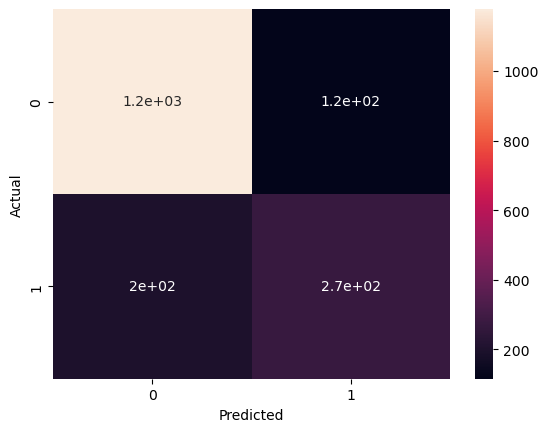

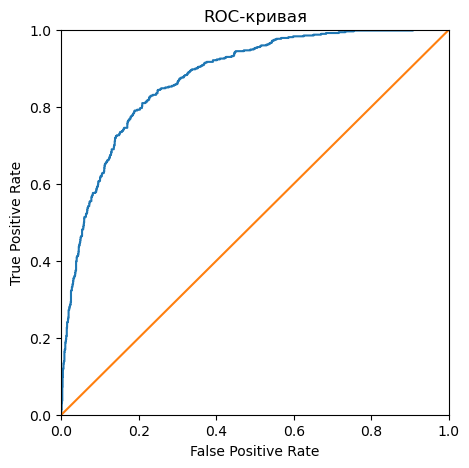

In [186]:
get_report(target_test, predictions_cat, probabilities_test_cat)

In [249]:
# train_data = features_train
# train_label = target_train
# test_data = features_test

In [250]:
# train_pool = Pool(train_data, 
#                   train_label, 
#                   cat_features=cat_features)
# test_pool = Pool(test_data, 
#                  cat_features=cat_features) 

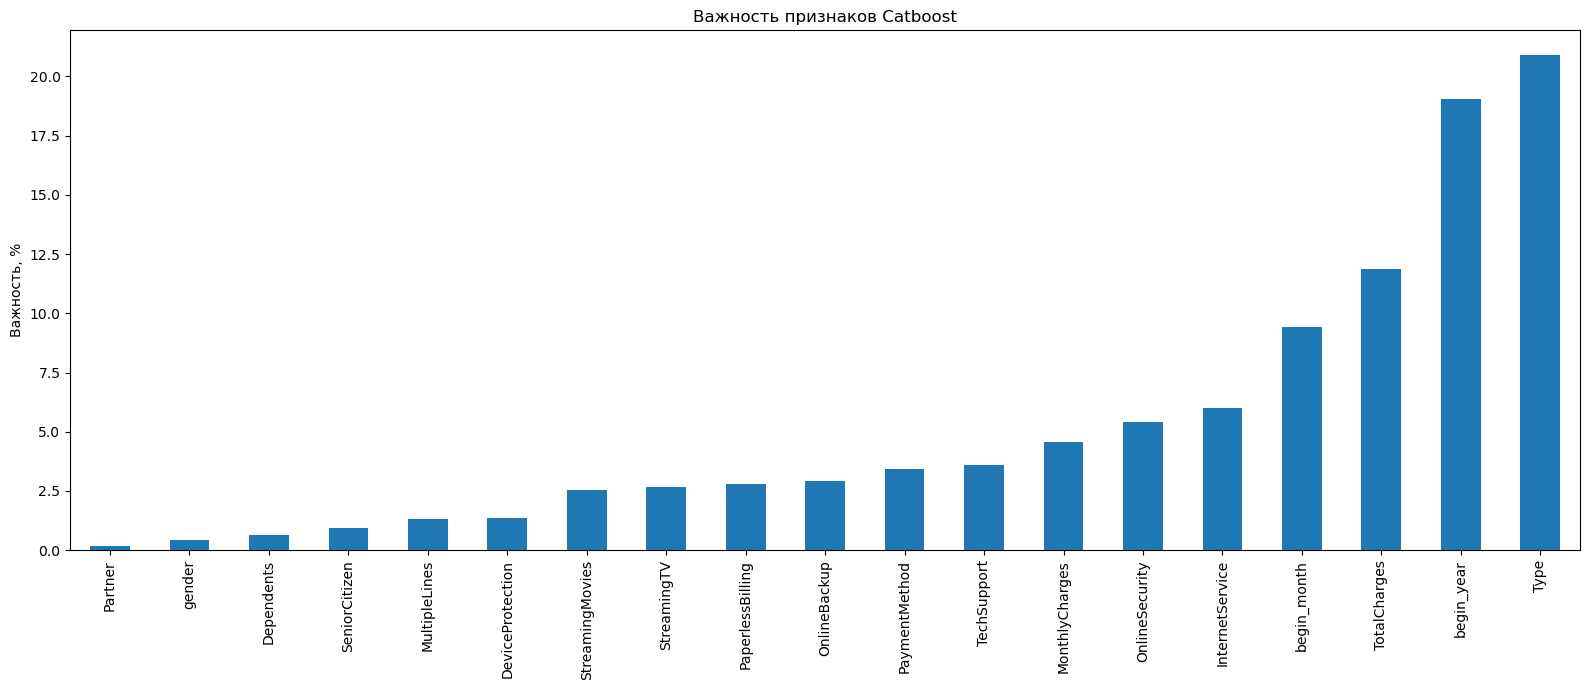

In [187]:
cat_imp = pd.Series(gs_cat.best_estimator_.get_feature_importance(),
                         features_train.columns).sort_values()
fig, ax = plt.subplots(figsize=(16,7))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков Catboost")
ax.set_ylabel('Важность, %')
fig.tight_layout()

## Нейросеть

In [295]:
col_transformer_net = make_column_transformer(
    (
        OneHotEncoder( drop='first', sparse=False),
        cat_col
    ),
    (
        StandardScaler(),
        num_col
    ),
    remainder='passthrough'
)
col_transformer_net = make_column_transformer(
    (
        OneHotEncoder( drop='first', sparse=False),
        cat_col
    ),
    (
        StandardScaler(),
        num_col
    ),
    remainder='passthrough'
)

In [112]:
col_transformer_ohe.fit(features_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['Type', 'PaperlessBilling', 'PaymentMethod',
                                  'gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'InternetService',
                                  'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies',
                                  'MultipleLines']),
                                ('standardscaler', StandardScaler(),
                                 ['MonthlyCharges', 'TotalCharges',
                                  'begin_year', 'begin_month'])])

In [113]:
# Применение преобразования ко всем данным
X_train_enc = col_transformer_ohe.transform(features_train)
X_test_enc = col_transformer_ohe.transform(features_test)

In [114]:
# Преобразование в тензоры PyTorch
X_train = torch.FloatTensor(X_train_enc)
X_test = torch.FloatTensor(X_test_enc)
y_train = torch.FloatTensor(target_train.values).reshape(-1, 1)
y_test = torch.FloatTensor(target_test.values).reshape(-1, 1)

In [115]:
X_train.size()[1]

30

In [116]:
# PyTorch classifier
class NetClassifier(nn.Module):
    def __init__(self, 
                 activation_1=nn.Sigmoid, 
                 activation_2=nn.Sigmoid, 
                 activation_3=nn.Sigmoid, 
                 n_neurons_1=20, 
                 n_neurons_2=5):
        super().__init__()
        self.layer1 = nn.Linear(X_train.size()[1], n_neurons_1)
        self.act1 = activation_1()
        self.layer2 = nn.Linear(n_neurons_1, n_neurons_2)
        self.act2 = activation_2()
        self.output = nn.Linear(n_neurons_2, 1)
        self.prob = activation_3()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.prob(self.output(x))
        return x

In [117]:
# create model with skorch
model_net = NeuralNetClassifier(
    NetClassifier,
    criterion=nn.BCELoss,
    optimizer=optim.Adam,
    verbose=False
)

In [118]:
# define the grid search parameters
param_grid = {
    'batch_size': [200],#[100, 200, 2000],
    'max_epochs': [1000],#, 2000],
    'module__activation_1': [nn.ReLU, nn.Tanh, nn.Sigmoid],
    'module__activation_2': [nn.ReLU, nn.Tanh, nn.Sigmoid],
    'module__activation_3': [nn.ReLU, nn.Tanh, nn.Sigmoid],
    'optimizer__lr': [ 2e-2, 1e-3],
    'module__n_neurons_1': [10, 20],
    'module__n_neurons_2': [5, 10]
}

In [119]:
%%time
# pipeline_net = make_pipeline(col_transformer_ohe, model_net)
grid = GridSearchCV(estimator=model_net, param_grid=param_grid, n_jobs=-1, cv=5, scoring='roc_auc')
grid_result = grid.fit(X_train, y_train)

CPU times: total: 5.2 s
Wall time: 5.45 s


In [120]:
grid_result.best_params_

{'batch_size': 200}

In [304]:
grid_result.best_params_

{'batch_size': 200,
 'max_epochs': 1000,
 'module__n_neurons_1': 10,
 'module__n_neurons_2': 10,
 'optimizer__lr': 0.001}

In [277]:
grid_result.best_params_

{'batch_size': 200,
 'max_epochs': 1000,
 'module__activation_1': torch.nn.modules.activation.Sigmoid,
 'module__activation_2': torch.nn.modules.activation.Sigmoid,
 'module__activation_3': torch.nn.modules.activation.Sigmoid,
 'optimizer__lr': 0.001}

In [305]:
predictions_net =  grid_result.best_estimator_.predict(X_test)

In [306]:
report = classification_report(y_test, predictions_net, target_names=['контракт не разорван', 'контракт разорван'])
print(report)

                      precision    recall  f1-score   support

контракт не разорван       0.86      0.91      0.88      1294
   контракт разорван       0.69      0.59      0.64       467

            accuracy                           0.82      1761
           macro avg       0.78      0.75      0.76      1761
        weighted avg       0.81      0.82      0.82      1761



In [307]:
# confusion_matrix = pd.crosstab(y_test, predictions_net)#, rownames=['Actual'], colnames=['Predicted'])
# sns.heatmap(confusion_matrix, annot=True);

In [308]:
predictions_net = grid_result.best_estimator_.predict(X_test)
probabilities_test_net = grid_result.best_estimator_.predict_proba(X_test)
probabilities_one_test_net = probabilities_test_net[:, 1]
auc_roc_net = roc_auc_score(y_test, probabilities_one_test_net)
auc_roc_net

0.865506753290595

In [213]:

predictions_net = grid_result.best_estimator_.predict(X_test)
probabilities_test_net = grid_result.best_estimator_.predict_proba(X_test)
probabilities_one_test_net = probabilities_test_net[:, 1]
auc_roc_net = roc_auc_score(y_test, probabilities_one_test_net)
auc_roc_net

0.8544790815127636

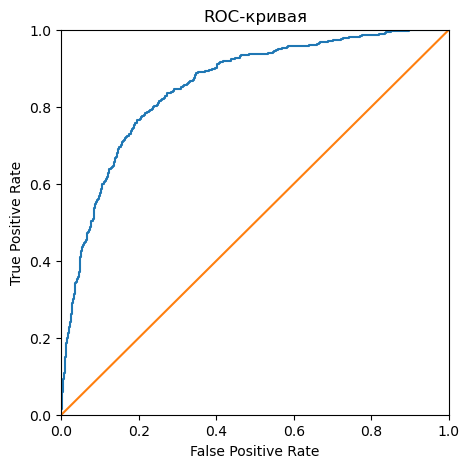

In [214]:
fpr, tpr, tresholds = roc_curve(y_test, probabilities_one_test_net)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0,1], [0,1], linestyle='-')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [221]:
len(target_test)

1761

In [217]:
predictions_lr

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

In [218]:
confusion_matrix

Predicted     0    1
Actual              
0          1030  264
1           100  367

In [223]:
y_test

tensor([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [1.]])

In [ ]:
predictions_net

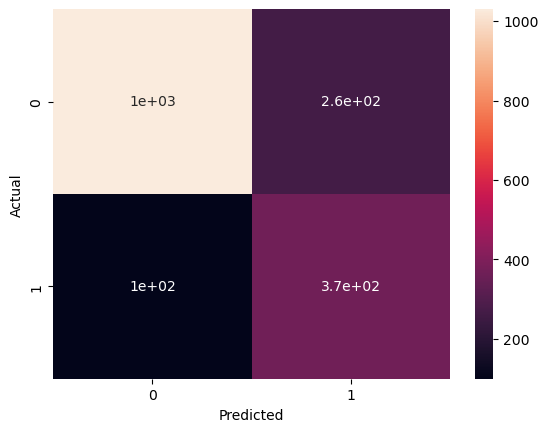

In [215]:
confusion_matrix = pd.crosstab(y_test, predictions_net, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True);

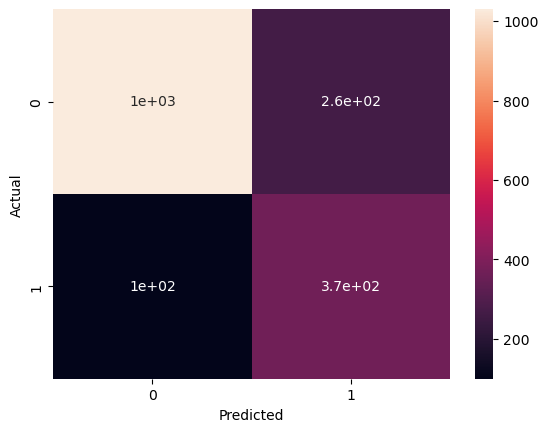

In [215]:
confusion_matrix = pd.crosstab(target_test, predictions_lr, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True);

In [197]:
%%time

predictions_net =  grid_result.best_estimator_.predict(X_test)
print('accuracy', accuracy_score(y_test, predictions_net))
print('precision', precision_score(y_test, predictions_net))
print('roc_auc', roc_auc_score(y_test, predictions_net))
ra_net = roc_auc_score(y_test, predictions_net)
print('roc_auc_score', ra_net)

accuracy 0.8126064735945485
precision 0.6760925449871465
roc_auc 0.7328983382370949
roc_auc_score 0.7328983382370949
CPU times: total: 125 ms
Wall time: 20.9 ms


In [199]:
predictions_net =  grid_result.best_estimator_.predict(X_test)
probabilities_test_net = grid_result.best_estimator_.predict_proba(X_test)

In [201]:
get_report(y_test, predictions_net, probabilities_test_net)

                      precision    recall  f1-score   support

контракт не разорван       0.85      0.90      0.88      1294
   контракт разорван       0.68      0.56      0.61       467

            accuracy                           0.81      1761
           macro avg       0.76      0.73      0.75      1761
        weighted avg       0.80      0.81      0.81      1761



AssertionError: arrays and names must have the same length

In [198]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.873456 using {'batch_size': 200, 'max_epochs': 1000, 'module__activation_1': <class 'torch.nn.modules.activation.Sigmoid'>, 'module__activation_2': <class 'torch.nn.modules.activation.Sigmoid'>, 'module__activation_3': <class 'torch.nn.modules.activation.Sigmoid'>, 'optimizer__lr': 0.001}


In [262]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.500000 (0.000000) with: {'batch_size': 200, 'max_epochs': 1000, 'module__activation_1': <class 'torch.nn.modules.activation.ReLU'>, 'module__activation_2': <class 'torch.nn.modules.activation.ReLU'>, 'module__activation_3': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer__lr': 0.3}
nan (nan) with: {'batch_size': 200, 'max_epochs': 1000, 'module__activation_1': <class 'torch.nn.modules.activation.ReLU'>, 'module__activation_2': <class 'torch.nn.modules.activation.ReLU'>, 'module__activation_3': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer__lr': 0.02}
nan (nan) with: {'batch_size': 200, 'max_epochs': 1000, 'module__activation_1': <class 'torch.nn.modules.activation.ReLU'>, 'module__activation_2': <class 'torch.nn.modules.activation.ReLU'>, 'module__activation_3': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer__lr': 0.001}
nan (nan) with: {'batch_size': 200, 'max_epochs': 1000, 'module__activation_1': <class 'torch.nn.modules.activation.ReLU'>, 'module__activati

In [263]:
report = classification_report(y_test, predictions_net, target_names=['not_at_fault', 'at_fault'])
print(report)

              precision    recall  f1-score   support

not_at_fault       0.83      0.88      0.86      1284
    at_fault       0.62      0.53      0.57       477

    accuracy                           0.79      1761
   macro avg       0.73      0.70      0.71      1761
weighted avg       0.78      0.79      0.78      1761



In [264]:
probabilities_test_net = grid_result.best_estimator_.predict_proba(X_test)

In [265]:
probabilities_one_test = probabilities_test_net[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Метрика auc_roc', round(auc_roc, 2))

Метрика auc_roc 0.83


In [195]:
probabilities_one_test = probabilities_test_net[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Метрика auc_roc', round(auc_roc, 2))

Метрика auc_roc 0.84


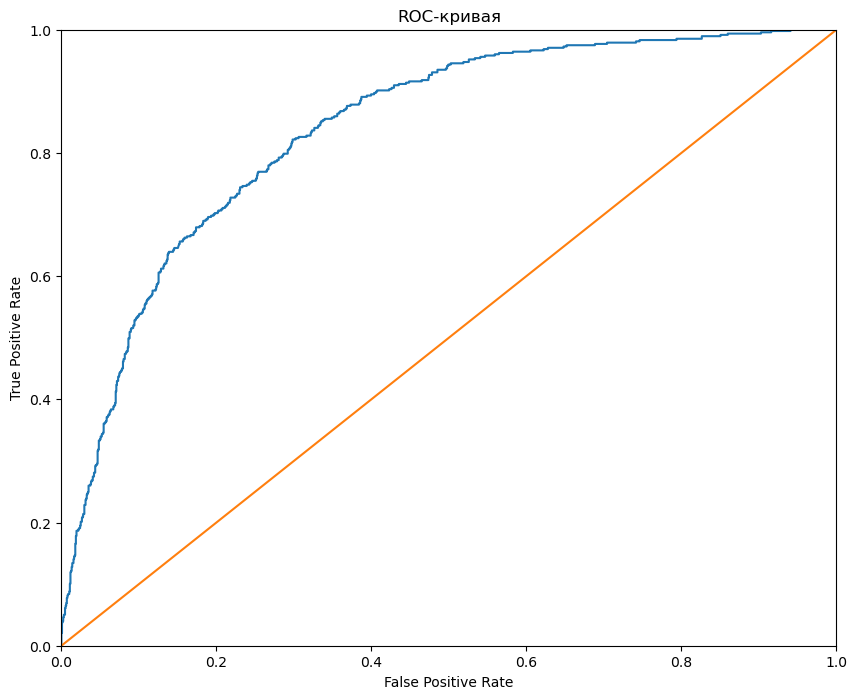

In [196]:
fpr, tpr, tresholds = roc_curve(target_test, probabilities_one_test)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0,1], [0,1], linestyle='-')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [197]:
 grid_result.best_estimator_.forward

<bound method NeuralNet.forward of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=NetClassifier(
    (layer): Linear(in_features=23, out_features=30, bias=True)
    (act): ReLU()
    (output): Linear(in_features=30, out_features=1, bias=True)
    (prob): Sigmoid()
  ),
)>

In [198]:
 grid_result.best_estimator_.module_

NetClassifier(
  (layer): Linear(in_features=23, out_features=30, bias=True)
  (act): ReLU()
  (output): Linear(in_features=30, out_features=1, bias=True)
  (prob): Sigmoid()
)

## Финальный отчёт

In [ ]:
final_report = pd.DataFrame({'model_name': ['LogisticRegression', 'Random Forest', 'Catboost', 'Neural_net'],
                            'f1_metric': [f1_lr, f1_RF, f1_cat, f1_net]})

### proba

In [373]:
query = '''
SELECT *
FROM telecom.contract;
'''


with engine.connect() as conn:
    contract = pd.read_sql(
        sql=query,
        con=conn.connection
    )
    
contract

query = '''
SELECT *
FROM telecom.personal;
'''

# personal = pd.read_sql_query(query, con=engine)
# personal

with engine.connect() as conn:
    personal = pd.read_sql(
        sql=query,
        con=conn.connection
    )
personal

query = '''
SELECT *
FROM telecom.internet;
'''

# internet = pd.read_sql_query(query, con=engine)
# internet

with engine.connect() as conn:
    internet = pd.read_sql(
        sql=query,
        con=conn.connection
    )
internet

query = '''
SELECT *
FROM telecom.phone;
'''

# phone = pd.read_sql_query(query, con=engine)
# phone

with engine.connect() as conn:
    phone = pd.read_sql(
        sql=query,
        con=conn.connection
    )
phone
internet.columns = internet.iloc[0]
internet = internet.drop(index=0)
phone.columns = phone.iloc[0]
phone = phone.drop(index=0)
phone

0     customerID MultipleLines
1     5575-GNVDE            No
2     3668-QPYBK            No
3     9237-HQITU            No
4     9305-CDSKC           Yes
5     1452-KIOVK           Yes
...          ...           ...
6357  2569-WGERO            No
6358  6840-RESVB           Yes
6359  2234-XADUH           Yes
6360  8361-LTMKD           Yes
6361  3186-AJIEK            No

[6361 rows x 2 columns]

In [374]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
import random
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report
from lightgbm import LGBMClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score,recall_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from functools import reduce
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")

In [375]:
data_frames = [contract, internet, personal, phone]
data = reduce(lambda  left,right: pd.merge(left ,right, on=['customerID'],
                                            how='outer'), data_frames)
data.head()

customerID   BeginDate     EndDate            Type PaperlessBilling  \
0  0002-ORFBO  2019-02-08        None        One year              Yes   
1  0003-MKNFE  2018-11-13        None  Month-to-month               No   
2  0004-TLHLJ  2019-04-16  2020-01-01  Month-to-month              Yes   
3  0011-IGKFF  2019-04-12  2020-01-01  Month-to-month              Yes   
4  0013-EXCHZ  2019-03-17  2019-12-01  Month-to-month              Yes   

      PaymentMethod  MonthlyCharges  TotalCharges InternetService  \
0      Mailed check            65.6        593.30             DSL   
1      Mailed check            59.9        542.40             DSL   
2  Electronic check            73.9        280.85     Fiber optic   
3  Electronic check            98.0       1237.85     Fiber optic   
4      Mailed check            83.9        267.40     Fiber optic   

  OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0             No          Yes               No         Yes         Yes   
1             No           No               No          No          No   
2             No           No              Yes          No          No   
3             No          Yes              Yes          No         Yes   
4             No           No               No         Yes         Yes   

  StreamingMovies  gender  SeniorCitizen Partner Dependents MultipleLines  
0              No  Female              0     Yes        Yes            No  
1             Yes    Male              0      No         No           Yes  
2              No    Male              0      No         No            No  
3             Yes    Male              1     Yes         No            No  
4              No  Female              1     Yes         No            No

In [376]:
data['target'] = [1 if i != 'No' else 0 for i in contract['EndDate']]
# заполним 'no' датой на которую предоставлены данные 2020-02-01
# data.loc[(data['EndDate'] == 'No'),'EndDate'] = '2020-02-01 00:00:00'
data['EndDate'] = data['EndDate'].fillna('2020-02-01')

data

customerID   BeginDate     EndDate            Type PaperlessBilling  \
0     0002-ORFBO  2019-02-08  2020-02-01        One year              Yes   
1     0003-MKNFE  2018-11-13  2020-02-01  Month-to-month               No   
2     0004-TLHLJ  2019-04-16  2020-01-01  Month-to-month              Yes   
3     0011-IGKFF  2019-04-12  2020-01-01  Month-to-month              Yes   
4     0013-EXCHZ  2019-03-17  2019-12-01  Month-to-month              Yes   
...          ...         ...         ...             ...              ...   
7038  9987-LUTYD  2018-12-23  2020-02-01        One year               No   
7039  9992-RRAMN  2019-01-24  2019-12-01  Month-to-month              Yes   
7040  9992-UJOEL  2019-08-20  2020-02-01  Month-to-month              Yes   
7041  9993-LHIEB  2019-02-17  2020-02-01        Two year               No   
7042  9995-HOTOH  2019-03-14  2020-02-01        Two year               No   

         PaymentMethod  MonthlyCharges  TotalCharges InternetService  \
0         Mailed check           65.60        593.30             DSL   
1         Mailed check           59.90        542.40             DSL   
2     Electronic check           73.90        280.85     Fiber optic   
3     Electronic check           98.00       1237.85     Fiber optic   
4         Mailed check           83.90        267.40     Fiber optic   
...                ...             ...           ...             ...   
7038      Mailed check           55.15        742.90             DSL   
7039  Electronic check           85.10       1873.70     Fiber optic   
7040      Mailed check           50.30         92.75             DSL   
7041      Mailed check           67.85       4627.65             DSL   
7042  Electronic check           59.00       3707.60             DSL   

     OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0                No          Yes               No         Yes         Yes   
1                No           No               No          No          No   
2                No           No              Yes          No          No   
3                No          Yes              Yes          No         Yes   
4                No           No               No         Yes         Yes   
...             ...          ...              ...         ...         ...   
7038            Yes           No               No         Yes          No   
7039             No           No               No          No          No   
7040             No          Yes               No          No          No   
7041            Yes           No              Yes         Yes          No   
7042            Yes          Yes              Yes          No         Yes   

     StreamingMovies  gender  SeniorCitizen Partner Dependents MultipleLines  \
0                 No  Female              0     Yes        Yes            No   
1                Yes    Male              0      No         No           Yes   
2                 No    Male              0      No         No            No   
3                Yes    Male              1     Yes         No            No   
4                 No  Female              1     Yes         No            No   
...              ...     ...            ...     ...        ...           ...   
7038              No  Female              0      No         No            No   
7039             Yes    Male              0     Yes         No           Yes   
7040              No    Male              0      No         No            No   
7041             Yes    Male              0     Yes        Yes            No   
7042             Yes    Male              0     Yes        Yes           NaN   

      target  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
7038       1  
7039       1  
7040       1  
7041       1  
7042       1  

[7043 rows x 21 columns]

In [378]:

# изменим тип данных начала и конца действия договора для анализа данных столбцов
data['EndDate'] = pd.to_datetime(data['EndDate'],format= "%Y-%m-%d")
data['BeginDate'] = pd.to_datetime(data['BeginDate'],format= "%Y-%m-%d")
data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')

In [379]:
#Переведем TotalCharges в числовой тип
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors ='coerce')


In [380]:
data['TotalCharges'].fillna(data[data['TotalCharges'].isnull()]['MonthlyCharges'],
                                          inplace = True)

In [381]:
data['period']=(data['EndDate']-data['BeginDate'])/np.timedelta64(1,'D')



In [382]:
data['period']

0       358.0
1       445.0
2       260.0
3       264.0
4       259.0
        ...  
7038    405.0
7039    311.0
7040    165.0
7041    349.0
7042    324.0
Name: period, Length: 7043, dtype: float64

In [383]:
data['period_payment']=(data['TotalCharges']/data['MonthlyCharges'])

In [384]:
data['MultipleLines'].fillna('no_phone', inplace = True)


In [385]:
data.fillna('no_internet', inplace = True)


In [386]:
data = data.set_index('customerID')


In [387]:
phik_overview = data.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'period', 'period_payment']


BeginDate  EndDate  Type  PaperlessBilling  PaymentMethod  \
BeginDate              1.00     0.52  0.13              0.04           0.10   
EndDate                0.52     1.00  0.36              0.16           0.21   
Type                   0.13     0.36  1.00              0.11           0.28   
PaperlessBilling       0.04     0.16  0.11              1.00           0.37   
PaymentMethod          0.10     0.21  0.28              0.37           1.00   
MonthlyCharges         0.19     0.32  0.39              0.47           0.40   
TotalCharges           0.00     0.25  0.51              0.21           0.35   
InternetService        0.13     0.29  0.51              0.23           0.32   
OnlineSecurity         0.16     0.31  0.64              0.21           0.32   
OnlineBackup           0.00     0.26  0.58              0.20           0.29   
DeviceProtection       0.16     0.25  0.63              0.20           0.30   
TechSupport            0.07     0.31  0.67              0.20           0.32   
StreamingTV            0.09     0.21  0.55              0.20           0.28   
StreamingMovies        0.08     0.21  0.55              0.20           0.29   
gender                 0.09     0.00  0.00              0.00           0.00   
SeniorCitizen          0.14     0.12  0.09              0.24           0.29   
Partner                0.14     0.12  0.18              0.01           0.24   
Dependents             0.08     0.13  0.15              0.17           0.22   
MultipleLines          0.00     0.04  0.24              0.10           0.17   
period                 0.98     0.03  0.04              0.05           0.00   
period_payment         0.13     0.40  0.67              0.00           0.37   

                  MonthlyCharges  TotalCharges  InternetService  \
BeginDate                   0.19          0.00             0.13   
EndDate                     0.32          0.25             0.29   
Type                        0.39          0.51             0.51   
PaperlessBilling            0.47          0.21             0.23   
PaymentMethod               0.40          0.35             0.32   
MonthlyCharges              1.00          0.76             0.92   
TotalCharges                0.76          1.00             0.51   
InternetService             0.92          0.51             1.00   
OnlineSecurity              0.81          0.53             0.95   
OnlineBackup                0.82          0.57             0.94   
DeviceProtection            0.83          0.57             0.94   
TechSupport                 0.82          0.54             0.95   
StreamingTV                 0.86          0.57             0.95   
StreamingMovies             0.86          0.57             0.95   
gender                      0.01          0.00             0.00   
SeniorCitizen               0.30          0.15             0.16   
Partner                     0.20          0.42             0.00   
Dependents                  0.18          0.11             0.11   
MultipleLines               0.71          0.49             0.74   
period                      0.02          0.01             0.03   
period_payment              0.42          0.85             0.04   

                  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
BeginDate                   0.16          0.00              0.16         0.07   
EndDate                     0.31          0.26              0.25         0.31   
Type                        0.64          0.58              0.63         0.67   
PaperlessBilling            0.21          0.20              0.20         0.20   
PaymentMethod               0.32          0.29              0.30         0.32   
MonthlyCharges              0.81          0.82              0.83         0.82   
TotalCharges                0.53          0.57              0.57         0.54   
InternetService             0.95          0.94              0.94         0.95   
OnlineSecurity              1.00          0.95              0.95         0.

In [388]:
cat_list = []
num_list = []

for i in data.columns:
    if data[i].dtype == 'object':
        cat_list.append(i)
    elif data[i].dtype == 'float64':
        num_list.append(i)
print(cat_list, num_list)

['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines'] ['MonthlyCharges', 'TotalCharges', 'period', 'period_payment']


In [389]:
data = data.drop(['BeginDate', 'EndDate', 'TotalCharges', 'period_payment'], axis = 1)
data.head()

Type PaperlessBilling     PaymentMethod  MonthlyCharges  \
customerID                                                                      
0002-ORFBO        One year              Yes      Mailed check            65.6   
0003-MKNFE  Month-to-month               No      Mailed check            59.9   
0004-TLHLJ  Month-to-month              Yes  Electronic check            73.9   
0011-IGKFF  Month-to-month              Yes  Electronic check            98.0   
0013-EXCHZ  Month-to-month              Yes      Mailed check            83.9   

           InternetService OnlineSecurity OnlineBackup DeviceProtection  \
customerID                                                                
0002-ORFBO             DSL             No          Yes               No   
0003-MKNFE             DSL             No           No               No   
0004-TLHLJ     Fiber optic             No           No              Yes   
0011-IGKFF     Fiber optic             No          Yes              Yes   
0013-EXCHZ     Fiber optic             No           No               No   

           TechSupport StreamingTV StreamingMovies  gender SeniorCitizen  \
customerID                                                                 
0002-ORFBO         Yes         Yes              No  Female             0   
0003-MKNFE          No          No             Yes    Male             0   
0004-TLHLJ          No          No              No    Male             0   
0011-IGKFF          No         Yes             Yes    Male             1   
0013-EXCHZ         Yes         Yes              No  Female             1   

           Partner Dependents MultipleLines  target  period  
customerID                                                   
0002-ORFBO     Yes        Yes            No       1   358.0  
0003-MKNFE      No         No           Yes       1   445.0  
0004-TLHLJ      No         No            No       1   260.0  
0011-IGKFF     Yes         No            No       1   264.0  
0013-EXCHZ     Yes         No            No       1   259.0

In [390]:
#Выделим тестовую выборку
features_train, test_features, target_train, test_target = train_test_split(data.drop('target', axis = 1),
                                          data['target'],
                                          test_size = 0.25,
                                          random_state = 141122,
                                          stratify = data['target'])
features_train.shape, test_features.shape, target_train.shape, test_target.shape

((5282, 17), (1761, 17), (5282,), (1761,))

In [391]:
features_train = features_train.join(pd.get_dummies(features_train[cat_list], drop_first=True))
features_train.head(5)

Type PaperlessBilling            PaymentMethod  \
customerID                                                             
1872-EBWSC        One year               No             Mailed check   
3987-KQDDU  Month-to-month               No         Electronic check   
8922-LIEGH  Month-to-month              Yes         Electronic check   
9375-MHRRS  Month-to-month               No             Mailed check   
0238-WHBIQ        Two year               No  Credit card (automatic)   

            MonthlyCharges InternetService OnlineSecurity OnlineBackup  \
customerID                                                               
1872-EBWSC           20.35     no_internet    no_internet  no_internet   
3987-KQDDU           75.60     Fiber optic            Yes           No   
8922-LIEGH           89.70     Fiber optic             No          Yes   
9375-MHRRS           50.05             DSL             No           No   
0238-WHBIQ           89.70             DSL            Yes          Yes   

           DeviceProtection  TechSupport  StreamingTV StreamingMovies  gender  \
customerID                                                                      
1872-EBWSC      no_internet  no_internet  no_internet     no_internet  Female   
3987-KQDDU               No           No           No              No    Male   
8922-LIEGH               No           No           No             Yes  Female   
9375-MHRRS               No          Yes           No              No    Male   
0238-WHBIQ              Yes          Yes          Yes             Yes    Male   

            ... TechSupport_Yes TechSupport_no_internet StreamingTV_Yes  \
customerID  ...                                                           
1872-EBWSC  ...           False                    True           False   
3987-KQDDU  ...           False                   False           False   
8922-LIEGH  ...           False                   False           False   
9375-MHRRS  ...            True                   False           False   
0238-WHBIQ  ...            True                   False            True   

           StreamingTV_no_internet  StreamingMovies_Yes  \
customerID                                                
1872-EBWSC                    True                False   
3987-KQDDU                   False                False   
8922-LIEGH                   False                 True   
9375-MHRRS                   False                False   
0238-WHBIQ                   False                 True   

            StreamingMovies_no_internet  gender_Male  SeniorCitizen_1  \
customerID                                                              
1872-EBWSC                         True        False            False   
3987-KQDDU                        False         True            False   
8922-LIEGH                        False        False             True   
9375-MHRRS                        False         True            False   
0238-WHBIQ                        False         True            False   

            Partner_Yes  Dependents_Yes  MultipleLines_Yes  \
customerID                                                   
1872-EBWSC        False           False              False   
3987-KQDDU        False           False              False   
8922-LIEGH        False           False               True   
9375-MHRRS        False           False              False   
0238-WHBIQ         True            True               True   

            MultipleLines_no_phone  
customerID                          
1872-EBWSC                   False  
3987-KQDDU                   False  
8922-LIEGH                   False  
9375-MHRRS                   False  
0238-WHBIQ                   False  

[5 rows x 43 columns]

In [392]:
test_features = test_features.join(pd.get_dummies(test_features[cat_list], drop_first=True))
test_features.head(5)

Type PaperlessBilling            PaymentMethod  \
customerID                                                             
6092-QZVPP  Month-to-month              Yes  Credit card (automatic)   
3338-CVVEH  Month-to-month               No         Electronic check   
0415-MOSGF  Month-to-month               No             Mailed check   
1074-WVEVG        One year               No             Mailed check   
2829-HYVZP        One year              Yes             Mailed check   

            MonthlyCharges InternetService OnlineSecurity OnlineBackup  \
customerID                                                               
6092-QZVPP           79.20             DSL            Yes           No   
3338-CVVEH           94.55     Fiber optic             No           No   
0415-MOSGF           44.40             DSL             No           No   
1074-WVEVG           20.35     no_internet    no_internet  no_internet   
2829-HYVZP           19.80     no_internet    no_internet  no_internet   

           DeviceProtection  TechSupport  StreamingTV StreamingMovies  gender  \
customerID                                                                      
6092-QZVPP              Yes          Yes          Yes             Yes    Male   
3338-CVVEH               No           No          Yes             Yes    Male   
0415-MOSGF               No           No           No              No  Female   
1074-WVEVG      no_internet  no_internet  no_internet     no_internet  Female   
2829-HYVZP      no_internet  no_internet  no_internet     no_internet    Male   

            ... TechSupport_Yes TechSupport_no_internet StreamingTV_Yes  \
customerID  ...                                                           
6092-QZVPP  ...            True                   False            True   
3338-CVVEH  ...           False                   False            True   
0415-MOSGF  ...           False                   False           False   
1074-WVEVG  ...           False                    True           False   
2829-HYVZP  ...           False                    True           False   

           StreamingTV_no_internet  StreamingMovies_Yes  \
customerID                                                
6092-QZVPP                   False                 True   
3338-CVVEH                   False                 True   
0415-MOSGF                   False                False   
1074-WVEVG                    True                False   
2829-HYVZP                    True                False   

            StreamingMovies_no_internet  gender_Male  SeniorCitizen_1  \
customerID                                                              
6092-QZVPP                        False         True            False   
3338-CVVEH                        False         True            False   
0415-MOSGF                        False        False            False   
1074-WVEVG                         True        False            False   
2829-HYVZP                         True         True            False   

            Partner_Yes  Dependents_Yes  MultipleLines_Yes  \
customerID                                                   
6092-QZVPP        False           False              False   
3338-CVVEH        False           False               True   
0415-MOSGF        False           False              False   
1074-WVEVG         True           False              False   
2829-HYVZP        False           False              False   

            MultipleLines_no_phone  
customerID                          
6092-QZVPP                   False  
3338-CVVEH                   False  
0415-MOSGF                   False  
1074-WVEVG                   False  
2829-HYVZP                   False  

[5 rows x 43 columns]

In [393]:
features_train.drop(cat_list, axis = 1, inplace = True)
test_features.drop(cat_list, axis = 1, inplace = True)

In [394]:
features_train.columns == test_features.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [411]:
cat_list = []
num_list = []

for i in data.columns:
    if data[i].dtype == 'object':
        cat_list.append(i)
    elif data[i].dtype == 'float64':
        num_list.append(i)
print(cat_list, num_list)
cat_features = cat_list
cat_features

['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines'] ['MonthlyCharges', 'period']


['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines']

In [414]:

parameters = {'cbc__depth':[3,1,2,6,4,5,7,8,9,10],
          'cbc__iterations':[250,100],
          'cbc__learning_rate':[0.001,0.01,0.1],
          'cbc__loss_function': ['Logloss', 'CrossEntropy']
          }
steps = [
    ('cbc', CatBoostClassifier(random_state=141122, auto_class_weights='Balanced'))
]
pipe = Pipeline(steps)

cbc = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
    
cbc.fit(features_train, target_train)

, cat_features=cat_features

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (323431497.py, line 7)

In [ ]:
cbc.best_score_

In [ ]:
roc_auc_score(test_target,cbc.predict_proba(test_features)[:, 1])

In [339]:
data_frames = [contract, internet, personal, phone]
data = reduce(lambda  left,right: pd.merge(left ,right, on=['customerID'],
                                            how='outer'), data_frames)

data['target'] = [1 if i != 'No' else 0 for i in contract['EndDate']]
# заполним 'no' датой на которую предоставлены данные 2020-02-01
data.loc[(data['EndDate'] == 'No'),'EndDate'] = '2020-02-01 00:00:00'

# изменим тип данных начала и конца действия договора для анализа данных столбцов
data['EndDate'] = pd.to_datetime(data['EndDate'],format= "%Y/%m/%d")
data['BeginDate'] = pd.to_datetime(data['BeginDate'],format= "%Y/%m/%d")

data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')

#Переведем TotalCharges в числовой тип
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors ='coerce')

data['TotalCharges'].fillna(data[data['TotalCharges'].isnull()]['MonthlyCharges'],
                                          inplace = True)

data['period_payment']=(data['TotalCharges']/data['MonthlyCharges'])

data['MultipleLines'].fillna('no_phone', inplace = True)
data.fillna('no_internet', inplace = True)



data = data.drop(['BeginDate', 'EndDate', 'TotalCharges', 'period_payment'], axis = 1)

data = data.set_index('customerID')
data.head()
cat_list = []
num_list = []

for i in data.columns:
    if data[i].dtype == 'object':
        cat_list.append(i)
    elif data[i].dtype == 'float64':
        num_list.append(i)
print(cat_list, num_list)




['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines'] ['MonthlyCharges']


In [ ]:
#Выделим тестовую выборку
features_train, test_features, target_train, test_target = train_test_split(data.drop('target', axis = 1),
                                          data['target'],
                                          test_size = 0.25,
                                          random_state = 141122,
                                          stratify = data['target'])
features_train.shape, test_features.shape, target_train.shape, test_target.shape

features_train = features_train.join(pd.get_dummies(features_train[cat_list], drop_first=True))
test_features = test_features.join(pd.get_dummies(test_features[cat_list], drop_first=True))
test_features.head(5)

features_train.drop(cat_list, axis = 1, inplace = True)
test_features.drop(cat_list, axis = 1, inplace = True)
features_train.columns == test_features.columns

In [338]:
parameters = {'cbc__depth':[3,1,2,6,4,5,7,8,9,10],
          'cbc__iterations':[250,100],
          'cbc__learning_rate':[0.001,0.01,0.1],
          'cbc__loss_function': ['Logloss', 'CrossEntropy']
          }
steps = [
    ('cbc', CatBoostClassifier(random_state=141122, auto_class_weights='Balanced'))
]
pipe = Pipeline(steps)

cbc = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
    
cbc.fit(features_train, target_train)

ValueError: 
All the 600 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\anaconda3\Lib\site-packages\catboost\core.py", line 5131, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\ProgramData\anaconda3\Lib\site-packages\catboost\core.py", line 2357, in _fit
    self._train(
  File "C:\ProgramData\anaconda3\Lib\site-packages\catboost\core.py", line 1761, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4624, in _catboost._CatBoost._train
  File "_catboost.pyx", line 4673, in _catboost._CatBoost._train
_catboost.CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/target/target_converter.cpp:375: Target contains only one unique value

--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\anaconda3\Lib\site-packages\catboost\core.py", line 5131, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\ProgramData\anaconda3\Lib\site-packages\catboost\core.py", line 2341, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\catboost\core.py", line 2268, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 6084, in _catboost._check_train_params
  File "_catboost.pyx", line 6103, in _catboost._check_train_params
_catboost.CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/catboost_options.cpp:614: class weights takes effect only with Logloss, MultiClass, MultiClassOneVsAll and user-defined loss functions


In [ ]:
res.loc[res.shape[0]]=['CatBoost',
                        cbc.best_score_,
                        features_train.shape[1]
                      ]
res